# Simulation of 1D Ising Model

## The method is from paper 2004 1D Ising Model

### Method 1: Combination of Classical and Quantum Algorithm

In [1]:
import numpy as np
import random
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
import matplotlib.pyplot as plt
from time import time

In [22]:
# Set Parameters
J = 1 # Coupling Strength
T = 1 # Temperature

# Calculate the Possibility
P = np.exp(-4 * J / T)

# Initialize the spins. This might be able to performed through quantum algorithms.
n = 5
spins = [1, -1, 1, -1, 1]
# This is a test with definite answer (probability will not be referred to when flipping. The answer should be [-1,1,-1,1,-1])

# Initialize the circuit
q = QuantumRegister(5)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

"""
For every loop, the program takes 3 spins from position i-1, i, and i+1 of the spins list. The program will then apply the Ising 
interaction on the spin at position i. After the ising interaction, the update spins is stored back to the spins list. The same 
process then repeated. If we don't consider the 1-dimensional ising model to be arranged in a circular shape (that is, the head spin
is not in neighbour with the tail spin), the program will apply ising interaction on all the spins except the first one and the last one.
"""


"""
In the following code, q[0] represents the spin i, q[1] represents the spins i-1, q[2] represents the spins i+1,
q[3] stands for the scratch qubit which will always be |0>, and q[4] represents the possibility to flip if change in energy is positive.
"""
for i in range (0, len(spins)):
    # Set the scratch and possibility qubits
    qc.reset(q[3])
    qc.reset(q[4])
    qc.u(2 * np.arccos(np.sqrt(1 - P)), 0, 0, q[4])
    
    #Set up the qubits
    if spins[i] == 1:
        qc.x(q[0])
    else:
        qc.reset(q[0])
    
    if spins[i - 1] == 1:
        qc.x(q[1])
    else:
        qc.reset(q[1])
    
    if spins[(i + 1) % len(spins)] == 1:
        qc.x(q[2])
    else:
        qc.reset(q[2])
    
    # Apply Ising Interaction (In a 'conservative' way, the code can be modified to be more efficient)
    # Operation 1
    qc.mcx([q[0], q[1], q[2]], q[3]) 
    
    #Operation 2
    for j in range(3):
        qc.x(q[j])
    qc.mcx([q[0], q[1], q[2]], q[3])
    for j in range(3):
        qc.x(q[j])
    
    # Operation 3
    qc.x(q[3])
    qc.cx(q[3], q[0])
    qc.x(q[3])
    
    # Operation 4
    qc.ccx(q[4], q[3], q[0])
    
    # Measurement
    qc.measure(q[0], c)
    backend = Aer.get_backend('qasm_simulator')
    shots = 1024
    results = execute(qc, backend, shots=shots).result()
    counts = results.get_counts()
    
    # Update spin i
    if len(counts.keys()) == 1:
        newstat = int(list(counts.keys())[0])
    else:
        if list(counts.values())[0] > list(counts.values())[1]:
            newstat = int(list(counts.keys())[0])
        else:
            newstat = int(list(counts.keys())[1])
    if newstat == 1:
        spins[i] = 1
    elif newstat == 0:
        spins[i] = -1
    
    for j in range(5):
        qc.reset(q[j])

print(spins)

[-1, 1, -1, 1, -1]


### Comparison of Classical 1D Ising Model and with Classic + Quantum Method

#### Traditional Method (in random order)

In [2]:
N = 4
J = -0.25*np.log(0.5)
T = 1

def energy(spin, J):
    E = 0
    for i in range(0, len(spin)):
        E += spin[i-1] * spin[i]
    E = -J * E
    return E

def deltaE(spin, ind, J):
    temp = spin.copy()
    temp[ind] = temp[ind] * (-1)
    dE = energy(temp, J) - energy(spin, J)
    return dE

dyct = {'[1, 1, 1, 1]':0, '[1, 1, 1, -1]':0, '[1, 1, -1, 1]':0, '[1, 1, -1, -1]':0,
       '[1, -1, 1, 1]':0, '[1, -1, 1, -1]':0, '[1, -1, -1, 1]':0, '[1, -1, -1, -1]':0,
       '[-1, 1, 1, 1]':0, '[-1, 1, 1, -1]':0, '[-1, 1, -1, 1]':0, '[-1, 1, -1, -1]':0,
       '[-1, -1, 1, 1]':0, '[-1, -1, 1, -1]':0, '[-1, -1, -1, 1]':0, '[-1, -1, -1, -1]':0,}

start = time()
for j in range(1000):
    
    spins = [1, 1, 1, 1, 1]
    
    for i in range (1000):
        index = random.randint(0, N-1)
        if deltaE(spins, index, J) <= 0 or ((deltaE(spins, index, J) > 0 and random.random() < np.exp(-deltaE(spins, index, J)/T))):
            spins[index] = spins[index] * (-1)
    dyct[str(spins)] = dyct[str(spins)] + 1

print(float(time() - start), 'seconds')
print(dyct)
plt.bar(dyct.keys(), dyct.values())
plt.xticks(ticks = list(dyct.keys()), rotation = 315)

KeyError: '[1, 1, -1, 1, 1]'

#### Classic + Quantum Method (in random order)

In [3]:
def randomindex4():
    tempq = QuantumRegister(2)
    tempc = ClassicalRegister(2)
    circ = QuantumCircuit(tempq, tempc)
    circ.h(tempq[0])
    circ.h(tempq[1])
    circ.measure(tempq, tempc)
    backend = Aer.get_backend('qasm_simulator')
    shots = 1024
    results = execute(circ, backend, shots=shots).result()
    counts = results.get_counts()
    
    if list(counts.keys())[0] == '00':
        return 0
    elif list(counts.keys())[0] == '01':
        return 1
    elif list(counts.keys())[0] == '10':
        return 2
    elif list(counts.keys())[0] == '11':
        return 3

12014.936329126358 seconds
{'[1, 1, 1, 1]': 124, '[1, 1, 1, -1]': 53, '[1, 1, -1, 1]': 63, '[1, 1, -1, -1]': 62, '[1, -1, 1, 1]': 61, '[1, -1, 1, -1]': 37, '[1, -1, -1, 1]': 43, '[1, -1, -1, -1]': 50, '[-1, 1, 1, 1]': 57, '[-1, 1, 1, -1]': 55, '[-1, 1, -1, 1]': 25, '[-1, 1, -1, -1]': 61, '[-1, -1, 1, 1]': 71, '[-1, -1, 1, -1]': 50, '[-1, -1, -1, 1]': 63, '[-1, -1, -1, -1]': 125}


([<matplotlib.axis.XTick at 0x1e486b48ac0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

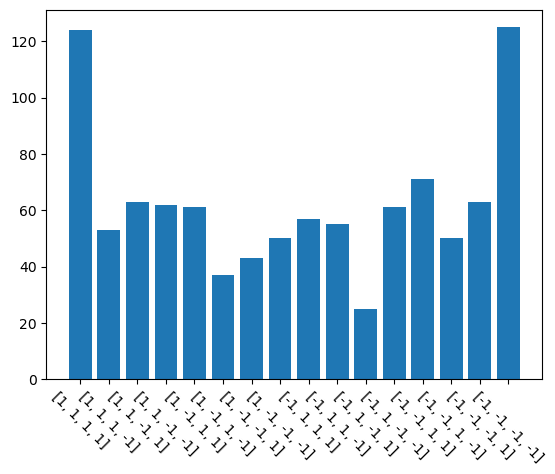

In [30]:
start = time()
dyct = {'[1, 1, 1, 1]':0, '[1, 1, 1, -1]':0, '[1, 1, -1, 1]':0, '[1, 1, -1, -1]':0,
       '[1, -1, 1, 1]':0, '[1, -1, 1, -1]':0, '[1, -1, -1, 1]':0, '[1, -1, -1, -1]':0,
       '[-1, 1, 1, 1]':0, '[-1, 1, 1, -1]':0, '[-1, 1, -1, 1]':0, '[-1, 1, -1, -1]':0,
       '[-1, -1, 1, 1]':0, '[-1, -1, 1, -1]':0, '[-1, -1, -1, 1]':0, '[-1, -1, -1, -1]':0,}

# Set Parameters
J = -0.25*np.log(0.5) # Coupling Strength
T = 1 # Temperature

# Calculate the Possibility
P = np.exp(-4 * J / T)


# Initialize the circuit
q = QuantumRegister(5)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

"""
For every loop, the program takes 3 spins from position i-1, i, and i+1 of the spins list. The program will then apply the Ising 
interaction on the spin at position i. After the ising interaction, the update spins is stored back to the spins list. The same 
process then repeated. If we don't consider the 1-dimensional ising model to be arranged in a circular shape (that is, the head spin
is not in neighbour with the tail spin), the program will apply ising interaction on all the spins except the first one and the last one.
"""


"""
In the following code, q[0] represents the spin i, q[1] represents the spins i-1, q[2] represents the spins i+1,
q[3] stands for the scratch qubit which will always be |0>, and q[4] represents the possibility to flip if change in energy is positive.
"""

n = 4

for t in range(1000):
    
    spins = [1, 1, 1, 1]
    
    for i in range (1000):
        
        index = randomindex4()
        
        qc = QuantumCircuit(q, c)
        
        qc.u(2 * np.arccos(np.sqrt(1 - P)), 0, 0, q[4])

        if spins[index] == 1:
            qc.x(q[0])
            
        if spins[index - 1] == 1:
            qc.x(q[1])

        if spins[(index + 1) % len(spins)] == 1:
            qc.x(q[2])

        # Operation 1
        qc.mcx([q[0], q[1], q[2]], q[3]) 

        for j in range(3):
            qc.x(q[j])
        qc.mcx([q[0], q[1], q[2]], q[3])
        for j in range(3):
            qc.x(q[j])

        qc.x(q[3])
        qc.cx(q[3], q[0])
        qc.x(q[3])

        qc.ccx(q[4], q[3], q[0])

        qc.measure(q[0], c)
        backend = Aer.get_backend('qasm_simulator')
        shots = 1024
        results = execute(qc, backend, shots=shots).result()
        counts = results.get_counts()

        if len(counts.keys()) == 1:
            newstat = int(list(counts.keys())[0])
        else:
            if list(counts.values())[0] > list(counts.values())[1]:
                newstat = int(list(counts.keys())[0])
            else:
                newstat = int(list(counts.keys())[1])
        if newstat == 1:
            spins[index] = 1
        elif newstat == 0:
            spins[index] = -1
    

    dyct[str(spins)] = dyct[str(spins)] + 1

print(float(time() - start), 'seconds')
print(dyct)
plt.bar(dyct.keys(), dyct.values())
plt.xticks(ticks = list(dyct.keys()), rotation = 315)

#### Traditional Method (in fixed order)

0.04005312919616699 seconds
{'[1, 1, 1, 1]': 67, '[1, 1, 1, -1]': 75, '[1, 1, -1, 1]': 0, '[1, 1, -1, -1]': 126, '[1, -1, 1, 1]': 0, '[1, -1, 1, -1]': 0, '[1, -1, -1, 1]': 0, '[1, -1, -1, -1]': 245, '[-1, 1, 1, 1]': 0, '[-1, 1, 1, -1]': 0, '[-1, 1, -1, 1]': 0, '[-1, 1, -1, -1]': 0, '[-1, -1, 1, 1]': 0, '[-1, -1, 1, -1]': 0, '[-1, -1, -1, 1]': 0, '[-1, -1, -1, -1]': 487}


([<matplotlib.axis.XTick at 0x249e9851340>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

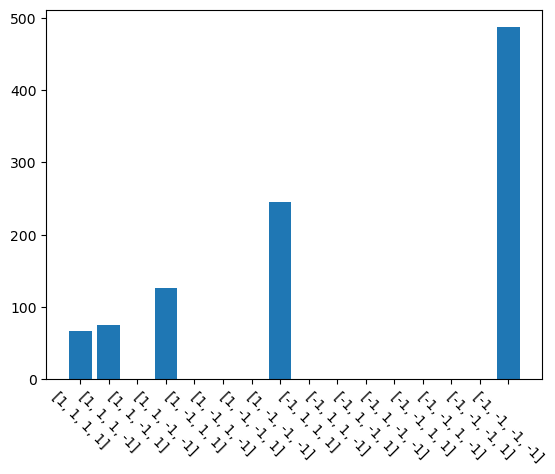

In [3]:
N = 4
J = -0.25*np.log(0.5)
T = 1

def energy(spin, J):
    E = 0
    for i in range(0, len(spin)):
        E += spin[i-1] * spin[i]
    E = -J * E
    return E

def deltaE(spin, ind, J):
    temp = spin.copy()
    temp[ind] = temp[ind] * (-1)
    dE = energy(temp, J) - energy(spin, J)
    return dE

start = time()
dyct = {'[1, 1, 1, 1]':0, '[1, 1, 1, -1]':0, '[1, 1, -1, 1]':0, '[1, 1, -1, -1]':0,
       '[1, -1, 1, 1]':0, '[1, -1, 1, -1]':0, '[1, -1, -1, 1]':0, '[1, -1, -1, -1]':0,
       '[-1, 1, 1, 1]':0, '[-1, 1, 1, -1]':0, '[-1, 1, -1, 1]':0, '[-1, 1, -1, -1]':0,
       '[-1, -1, 1, 1]':0, '[-1, -1, 1, -1]':0, '[-1, -1, -1, 1]':0, '[-1, -1, -1, -1]':0,}

for j in range(1000):
    spins = [1, 1, 1, 1]
    for i in range(len(spins)):
        index = i
        if deltaE(spins, index, J) <= 0 or (deltaE(spins, index, J) > 0 and random.random() < np.exp(-deltaE(spins, index, J)/T)):
            spins[index] = spins[index] * (-1)
    dyct[str(spins)] = dyct[str(spins)] + 1

print(float(time() - start), 'seconds')
print(dyct)
plt.bar(dyct.keys(), dyct.values())
plt.xticks(ticks = list(dyct.keys()), rotation = 315)

#### Classic + Quantum Method (in fixed order)

60.552945375442505 seconds
{'[1, 1, 1, 1]': 57, '[1, 1, 1, -1]': 64, '[1, 1, -1, 1]': 0, '[1, 1, -1, -1]': 127, '[1, -1, 1, 1]': 0, '[1, -1, 1, -1]': 0, '[1, -1, -1, 1]': 0, '[1, -1, -1, -1]': 260, '[-1, 1, 1, 1]': 0, '[-1, 1, 1, -1]': 0, '[-1, 1, -1, 1]': 0, '[-1, 1, -1, -1]': 0, '[-1, -1, 1, 1]': 0, '[-1, -1, 1, -1]': 0, '[-1, -1, -1, 1]': 0, '[-1, -1, -1, -1]': 492}


([<matplotlib.axis.XTick at 0x29e21da3310>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

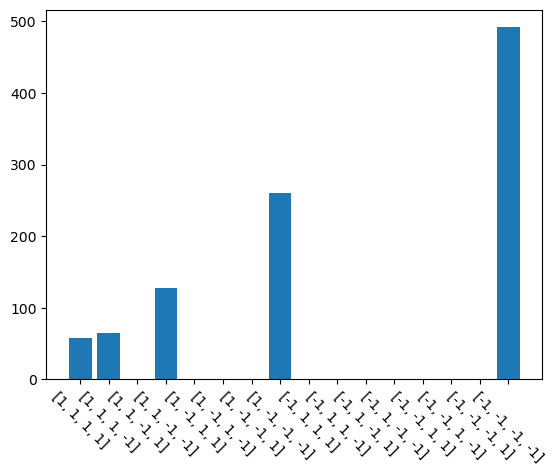

In [25]:
start = time()
dyct = {'[1, 1, 1, 1]':0, '[1, 1, 1, -1]':0, '[1, 1, -1, 1]':0, '[1, 1, -1, -1]':0,
       '[1, -1, 1, 1]':0, '[1, -1, 1, -1]':0, '[1, -1, -1, 1]':0, '[1, -1, -1, -1]':0,
       '[-1, 1, 1, 1]':0, '[-1, 1, 1, -1]':0, '[-1, 1, -1, 1]':0, '[-1, 1, -1, -1]':0,
       '[-1, -1, 1, 1]':0, '[-1, -1, 1, -1]':0, '[-1, -1, -1, 1]':0, '[-1, -1, -1, -1]':0,}

# Set Parameters
J = -0.25*np.log(0.5) # Coupling Strength
T = 1 # Temperature

# Calculate the Possibility
P = np.exp(-4 * J / T)


# Initialize the circuit
q = QuantumRegister(5)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

"""
For every loop, the program takes 3 spins from position i-1, i, and i+1 of the spins list. The program will then apply the Ising 
interaction on the spin at position i. After the ising interaction, the update spins is stored back to the spins list. The same 
process then repeated. If we don't consider the 1-dimensional ising model to be arranged in a circular shape (that is, the head spin
is not in neighbour with the tail spin), the program will apply ising interaction on all the spins except the first one and the last one.
"""


"""
In the following code, q[0] represents the spin i, q[1] represents the spins i-1, q[2] represents the spins i+1,
q[3] stands for the scratch qubit which will always be |0>, and q[4] represents the possibility to flip if change in energy is positive.
"""

n = 4

for t in range(1000):
    
    spins = [1, 1, 1, 1]
    
    for i in range (0, len(spins)):
        
        qc = QuantumCircuit(q, c)
        
        qc.u(2 * np.arccos(np.sqrt(1 - P)), 0, 0, q[4])

        if spins[i] == 1:
            qc.x(q[0])
            
        if spins[i - 1] == 1:
            qc.x(q[1])

        if spins[(i + 1) % len(spins)] == 1:
            qc.x(q[2])

        # Operation 1
        qc.mcx([q[0], q[1], q[2]], q[3]) 

        for j in range(3):
            qc.x(q[j])
        qc.mcx([q[0], q[1], q[2]], q[3])
        for j in range(3):
            qc.x(q[j])

        qc.x(q[3])
        qc.cx(q[3], q[0])
        qc.x(q[3])

        qc.ccx(q[4], q[3], q[0])

        qc.measure(q[0], c)
        backend = Aer.get_backend('qasm_simulator')
        shots = 1024
        results = execute(qc, backend, shots=shots).result()
        counts = results.get_counts()

        if len(counts.keys()) == 1:
            newstat = int(list(counts.keys())[0])
        else:
            if list(counts.values())[0] > list(counts.values())[1]:
                newstat = int(list(counts.keys())[0])
            else:
                newstat = int(list(counts.keys())[1])
        if newstat == 1:
            spins[i] = 1
        elif newstat == 0:
            spins[i] = -1

    dyct[str(spins)] = dyct[str(spins)] + 1

print(float(time() - start), 'seconds')
print(dyct)
plt.bar(dyct.keys(), dyct.values())
plt.xticks(ticks = list(dyct.keys()), rotation = 315)

#### Modularization

In [2]:
# Generate qubits with H gate and return the measurement outcomes in a list
def quantumrandom(N):
    n = int(np.ceil(np.log2(N)))
    tempq = QuantumRegister(n)
    tempc = ClassicalRegister(n)
    circ = QuantumCircuit(tempq, tempc)
    for numq in range(n):
        circ.h(tempq[numq])
    circ.measure(tempq, tempc)
    backend = Aer.get_backend('qasm_simulator')
    shots = 1024
    results = execute(circ, backend, shots=shots).result()
    counts = results.get_counts()
    return counts

# Convert a decimal number into a binary form
def dec2bin(num):
    l = []
    if num < 0:
        return '-' + dec2bin(abs(num))
    while True:
        num, remainder = divmod(num, 2)
        l.append(str(remainder))
        if num == 0:
            return ''.join(l[::-1])

# Fill up the empty space to make sure the binary number and outcomes in quantumrandom are of the same length
def fillupspace(binum, stands):
    num2fill = stands - len(binum)
    if num2fill == 0:
        return binum
    else:
        for temp1 in range (num2fill):
            binum = '0' + binum
        return binum

# Put up all possible Permutation in a list
def genresult(N):
    resultlist = []
    for temp2 in range(N):
        resultlist.append(N + 1)
        resultlist[temp2] = fillupspace(dec2bin(temp2),int(np.ceil(np.log2(N))))
    return resultlist

# Return a random index
def randomindex(N):
    outcome = quantumrandom(N)
    to_matched = genresult(N)
    for temp3 in range(len(to_matched)):
        if list(outcome.keys())[0] == to_matched[temp3]:
            return temp3
    return randomindex(N)

# Perform Ising Interactions
def isingAlgorithm(index):
        
    qc = QuantumCircuit(q, c)
        
    qc.u(2 * np.arccos(np.sqrt(1 - P)), 0, 0, q[4])

    if spins[index] == 1:
        qc.x(q[0])
            
    if spins[index - 1] == 1:
        qc.x(q[1])

    if spins[(index + 1) % len(spins)] == 1:
        qc.x(q[2])

    # Operation 1
    qc.mcx([q[0], q[1], q[2]], q[3]) 

    for temp4 in range(3):
        qc.x(q[j])
    qc.mcx([q[0], q[1], q[2]], q[3])
    for temp5 in range(3):
        qc.x(q[j])

    qc.x(q[3])
    qc.cx(q[3], q[0])
    qc.x(q[3])

    qc.ccx(q[4], q[3], q[0])

    qc.measure(q[0], c)
    backend = Aer.get_backend('qasm_simulator')
    shots = 1024
    results = execute(qc, backend, shots=shots).result()
    counts = results.get_counts()

    newstat = int(list(counts.keys())[0])
    if newstat == 1:
        spins[index] = 1
    elif newstat == 0:
        spins[index] = -1

In [14]:
# Modualized Quantum + Classic Model in fixed order
start = time()
dyct = {'[1, 1, 1, 1]':0, '[1, 1, 1, -1]':0, '[1, 1, -1, 1]':0, '[1, 1, -1, -1]':0,
       '[1, -1, 1, 1]':0, '[1, -1, 1, -1]':0, '[1, -1, -1, 1]':0, '[1, -1, -1, -1]':0,
       '[-1, 1, 1, 1]':0, '[-1, 1, 1, -1]':0, '[-1, 1, -1, 1]':0, '[-1, 1, -1, -1]':0,
       '[-1, -1, 1, 1]':0, '[-1, -1, 1, -1]':0, '[-1, -1, -1, 1]':0, '[-1, -1, -1, -1]':0,}

# Set Parameters
J = -0.25*np.log(0.5) # Coupling Strength
T = 1 # Temperature

# Calculate the Possibility
P = np.exp(-4 * J / T)

# Set the numbers of trials
trialnumbers = 1000

# Initialize the circuit
q = QuantumRegister(5)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

# Initialized Spins
inispins = [1, 1, 1, 1]

for totalloop in range(trialnumbers):
    
    spins = inispins.copy()
    
    for branchloop in range (0, len(spins)):
        isingAlgorithm(branchloop)

    dyct[str(spins)] = dyct[str(spins)] + 1

print(float(time() - start), 'seconds')
print(dyct)
plt.xticks(ticks = list(dyct.keys()), rotation = 315)
plt.bar(dyct.keys(), dyct.values())

NameError: name 'isingAlgorithm' is not defined

1.450226068496704 seconds
{'[1, 1, 1, 1]': 0, '[1, 1, 1, -1]': 0, '[1, 1, -1, 1]': 0, '[1, 1, -1, -1]': 1, '[1, -1, 1, 1]': 1, '[1, -1, 1, -1]': 0, '[1, -1, -1, 1]': 0, '[1, -1, -1, -1]': 0, '[-1, 1, 1, 1]': 0, '[-1, 1, 1, -1]': 2, '[-1, 1, -1, 1]': 1, '[-1, 1, -1, -1]': 0, '[-1, -1, 1, 1]': 3, '[-1, -1, 1, -1]': 0, '[-1, -1, -1, 1]': 0, '[-1, -1, -1, -1]': 2}


([<matplotlib.axis.XTick at 0x1e4871482e0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

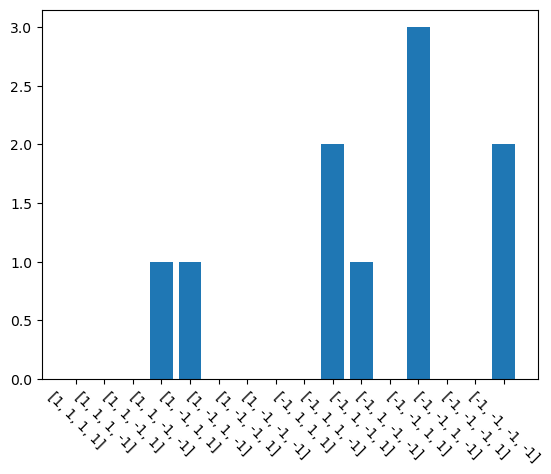

In [91]:
# Modualized Quantum + Classic Model in random order
start = time()
dyct = {'[1, 1, 1, 1]':0, '[1, 1, 1, -1]':0, '[1, 1, -1, 1]':0, '[1, 1, -1, -1]':0,
       '[1, -1, 1, 1]':0, '[1, -1, 1, -1]':0, '[1, -1, -1, 1]':0, '[1, -1, -1, -1]':0,
       '[-1, 1, 1, 1]':0, '[-1, 1, 1, -1]':0, '[-1, 1, -1, 1]':0, '[-1, 1, -1, -1]':0,
       '[-1, -1, 1, 1]':0, '[-1, -1, 1, -1]':0, '[-1, -1, -1, 1]':0, '[-1, -1, -1, -1]':0,}

# Set Parameters
J = -0.25*np.log(0.5) # Coupling Strength
T = 1 # Temperature

# Calculate the Possibility
P = np.exp(-4 * J / T)

# Set the numbers of trials
trialnumbers = 1000

# Initialize the circuit
q = QuantumRegister(5)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

# Initialized Spins
inispins = [1, 1, 1, 1]

for totalloop in range(trialnumbers):
    
    spins = inispins.copy()
    
    for branchloop in range(trialnumbers):
        isingAlgorithm(randomindex(len(spins)))

    dyct[str(spins)] = dyct[str(spins)] + 1

print(float(time() - start), 'seconds')
print(dyct)
plt.bar(dyct.keys(), dyct.values())
plt.xticks(ticks = list(dyct.keys()), rotation = 315)

#### 1D Ising Model with Constant External Magnetic Field

#### Modularization

In [5]:
# Ising interaction for magnitude of magnetic field B less than -2J
def iA_Bsmallern2J(index):
    
    # Initialize circuit
    qc = QuantumCircuit(q, c)
        
    qc.u(2 * np.arccos(np.sqrt(1 - P1)), 0, 0, q[6])
    qc.u(2 * np.arccos(np.sqrt(1 - P2)), 0, 0, q[7])
    qc.u(2 * np.arccos(np.sqrt(1 - P3)), 0, 0, q[8])

    if spins[index] == 1:
        qc.x(q[0])
            
    if spins[index - 1] == 1:
        qc.x(q[1])

    if spins[(index + 1) % len(spins)] == 1:
        qc.x(q[2])

    # Operation 1
    qc.x(q[0])
    qc.cx(q[0],q[3])
    qc.x(q[0])
    
    # Operation 2
    qc.x(q[1])
    qc.x(q[2])
    qc.ccx(q[1],q[2],q[4])
    qc.x(q[1])
    qc.x(q[2])
    
    # Operation 3
    qc.ccx(q[1],q[2],q[5])
    
    # Operation 4
    qc.x(q[3])
    qc.cx(q[3],q[0])
    qc.x(q[3])
    
    # Operation 5
    qc.x(q[4])
    qc.x(q[5])
    qc.mcx([q[3], q[4], q[5], q[8]], q[0])
    qc.x(q[4])
    qc.x(q[5])
    
    # Operation 6
    qc.mcx([q[3], q[4], q[6]], q[0])
    
    # Operation 7
    qc.mcx([q[3], q[5], q[7]], q[0])

    qc.measure(q[0], c)
    backend = Aer.get_backend('qasm_simulator')
    shots = 1024
    results = execute(qc, backend, shots=shots).result()
    counts = results.get_counts()

    newstat = int(list(counts.keys())[0])
    if newstat == 1:
        spins[index] = 1
    elif newstat == 0:
        spins[index] = -1

# Ising interaction for magnitude of magnetic field B equal to -2J
def iA_Bequaln2J(index):
    
    # Initialize circuit
    qc = QuantumCircuit(q, c)
        
    qc.u(2 * np.arccos(np.sqrt(1 - P1)), 0, 0, q[5])
    qc.u(2 * np.arccos(np.sqrt(1 - P2)), 0, 0, q[6])

    if spins[index] == 1:
        qc.x(q[0])
            
    if spins[index - 1] == 1:
        qc.x(q[1])

    if spins[(index + 1) % len(spins)] == 1:
        qc.x(q[2])

    # Operation 1
    qc.x(q[0])
    qc.x(q[2])
    qc.mcx([q[0],q[1],q[2]], q[3])
    qc.x(q[0])
    qc.x(q[2])
    
    # Operation 2
    qc.x(q[0])
    qc.x(q[1])
    qc.mcx([q[0],q[1],q[2]], q[3])
    qc.x(q[0])
    qc.x(q[1])
    
    # Operation 3
    qc.x(q[0])
    qc.x(q[1])
    qc.x(q[2])
    qc.mcx([q[0],q[1],q[2]], q[4])
    qc.x(q[0])
    qc.x(q[1])
    qc.x(q[2])
    
    # Operation 4
    qc.x(q[3])
    qc.x(q[4])
    qc.ccx(q[3],q[4], q[0])
    qc.x(q[3])
    qc.x(q[4])
    
    # Operation 5
    qc.ccx(q[3],q[5], q[0])
    
    # Operation 6
    qc.ccx(q[4],q[6], q[0])

    qc.measure(q[0], c)
    backend = Aer.get_backend('qasm_simulator')
    shots = 1024
    results = execute(qc, backend, shots=shots).result()
    counts = results.get_counts()

    newstat = int(list(counts.keys())[0])
    if newstat == 1:
        spins[index] = 1
    elif newstat == 0:
        spins[index] = -1

# Ising interaction for magnitude of magnetic field B larger than -2J but smaller than 0
def iA_Blargern2J(index):
    
    # Initialize circuit
    qc = QuantumCircuit(q, c)
        
    qc.u(2 * np.arccos(np.sqrt(1 - P1)), 0, 0, q[6])
    qc.u(2 * np.arccos(np.sqrt(1 - P2)), 0, 0, q[7])
    qc.u(2 * np.arccos(np.sqrt(1 - P3)), 0, 0, q[8])

    if spins[index] == 1:
        qc.x(q[0])
            
    if spins[index - 1] == 1:
        qc.x(q[1])

    if spins[(index + 1) % len(spins)] == 1:
        qc.x(q[2])
    
    # Operation 1
    qc.mcx([q[0],q[1],q[2]], q[3])

    # Operation 2
    qc.x(q[0])
    qc.x(q[1])
    qc.x(q[2])
    qc.mcx([q[0],q[1],q[2]], q[4])
    qc.x(q[0])
    qc.x(q[1])
    qc.x(q[2])
    
    # Operation 3
    qc.x(q[0])
    qc.x(q[1])
    qc.mcx([q[0],q[1],q[2]], q[5])
    qc.x(q[0])
    qc.x(q[1])
    
    # Operation 4
    qc.x(q[0])
    qc.x(q[2])
    qc.mcx([q[0],q[1],q[2]], q[5])
    qc.x(q[0])
    qc.x(q[2])
    
    # Operation 5
    qc.x(q[3])
    qc.x(q[4])
    qc.x(q[5])
    qc.mcx([q[3],q[4],q[5]], q[0])
    qc.x(q[3])
    qc.x(q[4])
    qc.x(q[5])
    
    # Operation 6
    qc.ccx(q[3],q[6], q[0])
    
    # Operation 7
    qc.ccx(q[4],q[7], q[0])
    
    # Operation 8
    qc.ccx(q[5],q[8], q[0])

    qc.measure(q[0], c)
    backend = Aer.get_backend('qasm_simulator')
    shots = 1024
    results = execute(qc, backend, shots=shots).result()
    counts = results.get_counts()

    newstat = int(list(counts.keys())[0])
    if newstat == 1:
        spins[index] = 1
    elif newstat == 0:
        spins[index] = -1

# Ising interaction for magnitude of magnetic field B larger than 0 but smaller than 2J
def iA_Bsmallerp2J(index):
    
    # Initialize circuit
    qc = QuantumCircuit(q, c)
        
    qc.u(2 * np.arccos(np.sqrt(1 - P1)), 0, 0, q[6])
    qc.u(2 * np.arccos(np.sqrt(1 - P2)), 0, 0, q[7])
    qc.u(2 * np.arccos(np.sqrt(1 - P3)), 0, 0, q[8])

    if spins[index] == 1:
        qc.x(q[0])
            
    if spins[index - 1] == 1:
        qc.x(q[1])

    if spins[(index + 1) % len(spins)] == 1:
        qc.x(q[2])
    
    # Operation 1
    qc.mcx([q[0],q[1],q[2]], q[3])

    # Operation 2
    qc.x(q[0])
    qc.x(q[1])
    qc.x(q[2])
    qc.mcx([q[0],q[1],q[2]], q[4])
    qc.x(q[0])
    qc.x(q[1])
    qc.x(q[2])
    
    # Operation 3
    qc.x(q[2])
    qc.mcx([q[0],q[1],q[2]], q[5])
    qc.x(q[2])
    
    # Operation 4
    qc.x(q[1])
    qc.mcx([q[0],q[1],q[2]], q[5])
    qc.x(q[1])
    
    # Operation 5
    qc.x(q[3])
    qc.x(q[4])
    qc.x(q[5])
    qc.mcx([q[3],q[4],q[5]], q[0])
    qc.x(q[3])
    qc.x(q[4])
    qc.x(q[5])
    
    # Operation 6
    qc.ccx(q[3],q[6], q[0])
    
    # Operation 7
    qc.ccx(q[4],q[7], q[0])
    
    # Operation 8
    qc.ccx(q[5],q[8], q[0])

    qc.measure(q[0], c)
    backend = Aer.get_backend('qasm_simulator')
    shots = 1024
    results = execute(qc, backend, shots=shots).result()
    counts = results.get_counts()

    newstat = int(list(counts.keys())[0])
    if newstat == 1:
        spins[index] = 1
    elif newstat == 0:
        spins[index] = -1

# Ising interaction for magnitude of magnetic field B equal to 2J
def iA_Bequalp2J(index):
    # Initialize circuit
    qc = QuantumCircuit(q, c)
        
    qc.u(2 * np.arccos(np.sqrt(1 - P1)), 0, 0, q[5])
    qc.u(2 * np.arccos(np.sqrt(1 - P2)), 0, 0, q[6])

    if spins[index] == 1:
        qc.x(q[0])
            
    if spins[index - 1] == 1:
        qc.x(q[1])

    if spins[(index + 1) % len(spins)] == 1:
        qc.x(q[2])

    # Operation 1
    qc.x(q[2])
    qc.mcx([q[0],q[1],q[2]], q[3])
    qc.x(q[2])
    
    # Operation 2
    qc.x(q[1])
    qc.mcx([q[0],q[1],q[2]], q[3])
    qc.x(q[1])
    
    # Operation 3
    qc.mcx([q[0],q[1],q[2]], q[4])
    
    # Operation 4
    qc.x(q[3])
    qc.x(q[4])
    qc.ccx(q[3],q[4], q[0])
    qc.x(q[3])
    qc.x(q[4])
    
    # Operation 5
    qc.ccx(q[3],q[5], q[0])
    
    # Operation 6
    qc.ccx(q[4],q[6], q[0])

    qc.measure(q[0], c)
    backend = Aer.get_backend('qasm_simulator')
    shots = 1024
    results = execute(qc, backend, shots=shots).result()
    counts = results.get_counts()

    newstat = int(list(counts.keys())[0])
    if newstat == 1:
        spins[index] = 1
    elif newstat == 0:
        spins[index] = -1

# Ising interaction for magnitude of magnetic field B larger than 2J
def iA_Blargerp2J(index):
    
    # Initialize circuit
    qc = QuantumCircuit(q, c)
        
    qc.u(2 * np.arccos(np.sqrt(1 - P1)), 0, 0, q[6])
    qc.u(2 * np.arccos(np.sqrt(1 - P2)), 0, 0, q[7])
    qc.u(2 * np.arccos(np.sqrt(1 - P3)), 0, 0, q[8])

    if spins[index] == 1:
        qc.x(q[0])
            
    if spins[index - 1] == 1:
        qc.x(q[1])

    if spins[(index + 1) % len(spins)] == 1:
        qc.x(q[2])

    # Operation 1
    qc.cx(q[0],q[3])
    
    # Operation 2
    qc.ccx(q[1],q[2],q[4])
    
    # Operation 3
    qc.x(q[1])
    qc.x(q[2])
    qc.ccx(q[1],q[2],q[5])
    qc.x(q[1])
    qc.x(q[2])
    
    # Operation 4
    qc.x(q[3])
    qc.cx(q[3],q[0])
    qc.x(q[3])
    
    # Operation 5
    qc.x(q[4])
    qc.x(q[5])
    qc.mcx([q[3], q[4], q[5], q[8]], q[0])
    qc.x(q[4])
    qc.x(q[5])
    
    # Operation 6
    qc.mcx([q[3], q[4], q[6]], q[0])
    
    # Operation 7
    qc.mcx([q[3], q[5], q[7]], q[0])

    qc.measure(q[0], c)
    backend = Aer.get_backend('qasm_simulator')
    shots = 1024
    results = execute(qc, backend, shots=shots).result()
    counts = results.get_counts()

    newstat = int(list(counts.keys())[0])
    if newstat == 1:
        spins[index] = 1
    elif newstat == 0:
        spins[index] = -1

#### Traditional Method with External Magnetic Field

0.027019023895263672 seconds
{'[1, 1, 1, 1]': 214, '[1, 1, 1, -1]': 123, '[1, 1, -1, 1]': 0, '[1, 1, -1, -1]': 0, '[1, -1, 1, 1]': 182, '[1, -1, 1, -1]': 100, '[1, -1, -1, 1]': 0, '[1, -1, -1, -1]': 0, '[-1, 1, 1, 1]': 74, '[-1, 1, 1, -1]': 56, '[-1, 1, -1, 1]': 0, '[-1, 1, -1, -1]': 0, '[-1, -1, 1, 1]': 123, '[-1, -1, 1, -1]': 128, '[-1, -1, -1, 1]': 0, '[-1, -1, -1, -1]': 0}


([<matplotlib.axis.XTick at 0x1c20a0c53a0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

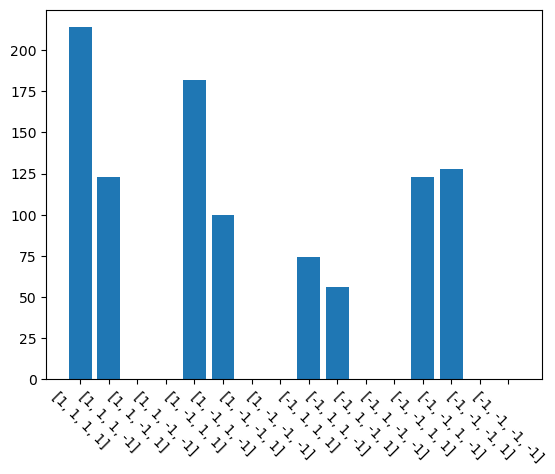

In [43]:
# Traditional method for simulating 1D Ising model with external magnetic field
N = 4
J = -0.25 * np.log(0.5) - 0.1
T = 1
B = -0.5 * np.log(0.5)

def energy(spin):
    EJ = 0
    EB = 0
    for temp6 in range(0, len(spin)):
        EJ += spin[temp6 - 1] * spin[temp6]
    for temp7 in range(len(spin)):
        EB += spin[temp7]
    E = -J * EJ - B * EB
    return E

def deltaE(spin, ind):
    temp = spin.copy()
    temp[ind] = temp[ind] * (-1)
    dE = energy(temp) - energy(spin)
    return dE

start = time()
dyct = {'[1, 1, 1, 1]':0, '[1, 1, 1, -1]':0, '[1, 1, -1, 1]':0, '[1, 1, -1, -1]':0,
       '[1, -1, 1, 1]':0, '[1, -1, 1, -1]':0, '[1, -1, -1, 1]':0, '[1, -1, -1, -1]':0,
       '[-1, 1, 1, 1]':0, '[-1, 1, 1, -1]':0, '[-1, 1, -1, 1]':0, '[-1, 1, -1, -1]':0,
       '[-1, -1, 1, 1]':0, '[-1, -1, 1, -1]':0, '[-1, -1, -1, 1]':0, '[-1, -1, -1, -1]':0,}

for j in range(1000):
    spins = [1, 1, -1, 1]
    for i in range(len(spins)):
        index = i
        if deltaE(spins, index) <= 0 or (deltaE(spins, index) > 0 and random.random() < np.exp(-deltaE(spins, index)/T)):
            spins[index] = spins[index] * (-1)
    dyct[str(spins)] = dyct[str(spins)] + 1

print(float(time() - start), 'seconds')
print(dyct)
plt.bar(dyct.keys(), dyct.values())
plt.xticks(ticks = list(dyct.keys()), rotation = 315)

In [70]:
print(energy([-1,-1,-1,-1]))
print(deltaE([-1,-1,-1,-1],0))

4
2


#### Test for situation B<-2J (only P3)

115.06522917747498 seconds
{'[1, 1, 1, 1]': 0, '[1, 1, 1, -1]': 0, '[1, 1, -1, 1]': 0, '[1, 1, -1, -1]': 0, '[1, -1, 1, 1]': 0, '[1, -1, 1, -1]': 0, '[1, -1, -1, 1]': 0, '[1, -1, -1, -1]': 0, '[-1, 1, 1, 1]': 0, '[-1, 1, 1, -1]': 0, '[-1, 1, -1, 1]': 0, '[-1, 1, -1, -1]': 0, '[-1, -1, 1, 1]': 0, '[-1, -1, 1, -1]': 490, '[-1, -1, -1, 1]': 0, '[-1, -1, -1, -1]': 510}


([<matplotlib.axis.XTick at 0x29e894cb070>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

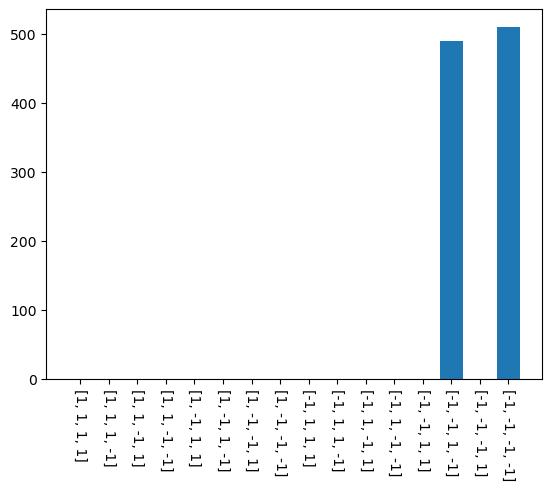

In [37]:
# Test for Quantum + Classic Model with magnetic field in fixed order
start = time()
dyct = {'[1, 1, 1, 1]':0, '[1, 1, 1, -1]':0, '[1, 1, -1, 1]':0, '[1, 1, -1, -1]':0,
       '[1, -1, 1, 1]':0, '[1, -1, 1, -1]':0, '[1, -1, -1, 1]':0, '[1, -1, -1, -1]':0,
       '[-1, 1, 1, 1]':0, '[-1, 1, 1, -1]':0, '[-1, 1, -1, 1]':0, '[-1, 1, -1, -1]':0,
       '[-1, -1, 1, 1]':0, '[-1, -1, 1, -1]':0, '[-1, -1, -1, 1]':0, '[-1, -1, -1, -1]':0}

# Set Parameters
# Parameters are set so that the possibility of each flip is 0.5
J = -0.25 * np.log(0.5) - 0.1 # Coupling Strength
T = 1 # Temperature
B = 0.5 * np.log(0.5) # Magnitude of Magnetic field

# Calculate the Possibility
P1 = np.exp(-((-4 * J - 2* B) / T))
P2 = np.exp(-((4 * J - 2* B) / T))
P3 = np.exp(-((-2 * B)/ T))

# Set Trial Numbers
trialnumbers = 1000

# Initialize the circuit
q = QuantumRegister(9)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

# Initialized Spins
inispins = [1, 1, -1, 1]

for totalloop in range(trialnumbers):
    
    spins = inispins.copy()
    
    for branchloop in range(len(spins)):
        iA_Bsmallern2J(branchloop)

    dyct[str(spins)] = dyct[str(spins)] + 1

print(float(time() - start), 'seconds')
# Result should be: [-1, -1, 1, -1]: 500 (0.5); [-1, -1, -1, -1]: 500 (0.5)
print(dyct)
plt.bar(dyct.keys(), dyct.values())
plt.xticks(ticks = list(dyct.keys()), rotation = 270)

#### Test for situation B<-2J (P1, P2, and P3)

96.03384971618652 seconds
{'[1, 1, 1, 1]': 56, '[1, 1, 1, -1]': 95, '[1, 1, -1, 1]': 80, '[1, 1, -1, -1]': 85, '[1, -1, 1, 1]': 88, '[1, -1, 1, -1]': 154, '[1, -1, -1, 1]': 57, '[1, -1, -1, -1]': 59, '[-1, 1, 1, 1]': 44, '[-1, 1, 1, -1]': 66, '[-1, 1, -1, 1]': 87, '[-1, 1, -1, -1]': 28, '[-1, -1, 1, 1]': 31, '[-1, -1, 1, -1]': 37, '[-1, -1, -1, 1]': 19, '[-1, -1, -1, -1]': 14}


([<matplotlib.axis.XTick at 0x29e898e9fa0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

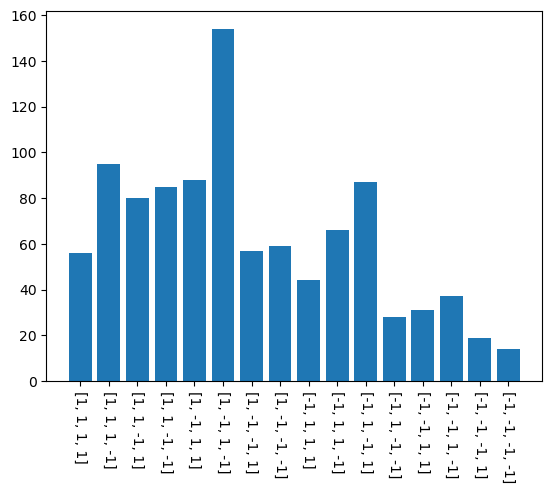

In [46]:
# Test for Quantum + Classic Model with magnetic field in fixed order
start = time()
dyct = {'[1, 1, 1, 1]':0, '[1, 1, 1, -1]':0, '[1, 1, -1, 1]':0, '[1, 1, -1, -1]':0,
       '[1, -1, 1, 1]':0, '[1, -1, 1, -1]':0, '[1, -1, -1, 1]':0, '[1, -1, -1, -1]':0,
       '[-1, 1, 1, 1]':0, '[-1, 1, 1, -1]':0, '[-1, 1, -1, 1]':0, '[-1, 1, -1, -1]':0,
       '[-1, -1, 1, 1]':0, '[-1, -1, 1, -1]':0, '[-1, -1, -1, 1]':0, '[-1, -1, -1, -1]':0}

# Set Parameters
# Parameters are set so that the possibility of each flip is 0.5
J = -0.25 * np.log(0.5) - 0.1 # Coupling Strength
T = 1 # Temperature
B = 0.5 * np.log(0.5) # Magnitude of Magnetic field

# Calculate the Possibility
P1 = np.exp(-((-4 * J - 2* B) / T))
P2 = np.exp(-((4 * J - 2* B) / T))
P3 = np.exp(-((-2 * B)/ T))

# Set Trial Numbers
trialnumbers = 1000

# Initialize the circuit
q = QuantumRegister(9)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

# Initialized Spins
inispins = [-1, -1, -1, -1]

for totalloop in range(trialnumbers):
    
    spins = inispins.copy()
    
    for branchloop in range(len(spins)):
        iA_Bsmallern2J(branchloop)

    dyct[str(spins)] = dyct[str(spins)] + 1

print(float(time() - start), 'seconds')
"""
Result should be:
[1, 1, 1, 1]:62, [1, 1, 1, -1]:105, [1, 1, -1, 1]:83, [1, 1, -1, -1]:83,
[1, -1, 1, 1]:83, [1, -1, 1, -1]:140, [1, -1, -1, 1]:55, [1, -1, -1, -1]:55,
[-1, 1, 1, 1]:55, [-1, 1, 1, -1]:55, [-1, 1, -1, 1]:74, [-1, 1, -1, -1]:36,
[-1, -1, 1, 1]:36, [-1, -1, 1, -1]:36, [-1, -1, -1, 1]:24, [-1, -1, -1, -1]:11
"""
print(dyct)
plt.bar(dyct.keys(), dyct.values())
plt.xticks(ticks = list(dyct.keys()), rotation = 270)

#### Test for situation B=-2J (P1 and P2)

118.87530183792114 seconds
{'[1, 1, 1, 1]': 0, '[1, 1, 1, -1]': 0, '[1, 1, -1, 1]': 0, '[1, 1, -1, -1]': 0, '[1, -1, 1, 1]': 0, '[1, -1, 1, -1]': 0, '[1, -1, -1, 1]': 0, '[1, -1, -1, -1]': 0, '[-1, 1, 1, 1]': 56, '[-1, 1, 1, -1]': 73, '[-1, 1, -1, 1]': 37, '[-1, 1, -1, -1]': 83, '[-1, -1, 1, 1]': 74, '[-1, -1, 1, -1]': 91, '[-1, -1, -1, 1]': 154, '[-1, -1, -1, -1]': 432}


([<matplotlib.axis.XTick at 0x29e8b0b5c40>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

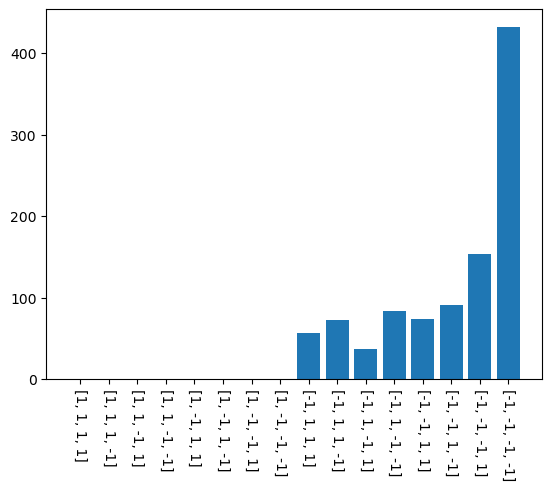

In [80]:
# Test for Quantum + Classic Model with magnetic field in fixed order
start = time()
dyct = {'[1, 1, 1, 1]':0, '[1, 1, 1, -1]':0, '[1, 1, -1, 1]':0, '[1, 1, -1, -1]':0,
       '[1, -1, 1, 1]':0, '[1, -1, 1, -1]':0, '[1, -1, -1, 1]':0, '[1, -1, -1, -1]':0,
       '[-1, 1, 1, 1]':0, '[-1, 1, 1, -1]':0, '[-1, 1, -1, 1]':0, '[-1, 1, -1, -1]':0,
       '[-1, -1, 1, 1]':0, '[-1, -1, 1, -1]':0, '[-1, -1, -1, 1]':0, '[-1, -1, -1, -1]':0}

# Set Parameters
# Parameters are set so that the possibility of each flip is 0.5
J = -0.25 * np.log(0.5) # Coupling Strength
T = 1 # Temperature
B = 0.5 * np.log(0.5) # Magnitude of Magnetic field

# Calculate the Possibility
P1 = np.exp(-((-2 * B)/ T))
P2 = np.exp(-((4 * J - 2* B) / T))

# Set Trial Numbers
trialnumbers = 1000

# Initialize the circuit
q = QuantumRegister(7)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

# Initialized Spins
inispins = [1, -1, -1, -1]

for totalloop in range(trialnumbers):
    
    spins = inispins.copy()
    
    for branchloop in range(len(spins)):
        iA_Bequaln2J(branchloop)

    dyct[str(spins)] = dyct[str(spins)] + 1

print(float(time() - start), 'seconds')
"""
Result should be:
[1, 1, 1, 1]:0, [1, 1, 1, -1]:0, [1, 1, -1, 1]:0, [1, 1, -1, -1]:0,
[1, -1, 1, 1]:0, [1, -1, 1, -1]:0, [1, -1, -1, 1]:0, [1, -1, -1, -1]:0,
[-1, 1, 1, 1]:62, [-1, 1, 1, -1]:62, [-1, 1, -1, 1]:31, [-1, 1, -1, -1]:93,
[-1, -1, 1, 1]:93, [-1, -1, 1, -1]:93, [-1, -1, -1, 1]:140, [-1, -1, -1, -1]:421
"""
print(dyct)
plt.bar(dyct.keys(), dyct.values())
plt.xticks(ticks = list(dyct.keys()), rotation = 270)

#### Test for situation -2J<B<0 (P1 and P3)

74.36164832115173 seconds
{'[1, 1, 1, 1]': 0, '[1, 1, 1, -1]': 0, '[1, 1, -1, 1]': 0, '[1, 1, -1, -1]': 0, '[1, -1, 1, 1]': 46, '[1, -1, 1, -1]': 105, '[1, -1, -1, 1]': 0, '[1, -1, -1, -1]': 148, '[-1, 1, 1, 1]': 0, '[-1, 1, 1, -1]': 0, '[-1, 1, -1, 1]': 0, '[-1, 1, -1, -1]': 0, '[-1, -1, 1, 1]': 0, '[-1, -1, 1, -1]': 371, '[-1, -1, -1, 1]': 0, '[-1, -1, -1, -1]': 330}


([<matplotlib.axis.XTick at 0x29e8cc713a0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

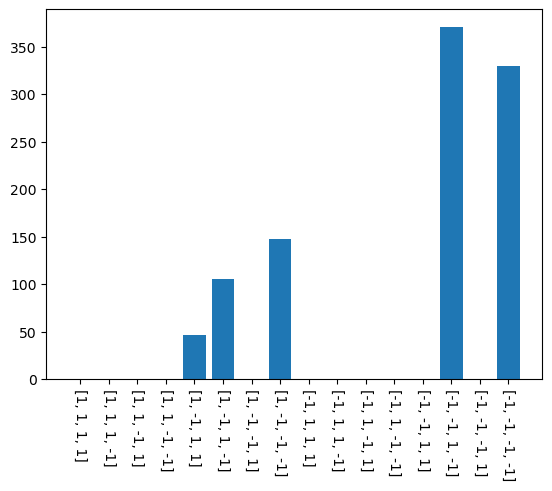

In [95]:
# Test for Quantum + Classic Model with magnetic field in fixed order
start = time()
dyct = {'[1, 1, 1, 1]':0, '[1, 1, 1, -1]':0, '[1, 1, -1, 1]':0, '[1, 1, -1, -1]':0,
       '[1, -1, 1, 1]':0, '[1, -1, 1, -1]':0, '[1, -1, -1, 1]':0, '[1, -1, -1, -1]':0,
       '[-1, 1, 1, 1]':0, '[-1, 1, 1, -1]':0, '[-1, 1, -1, 1]':0, '[-1, 1, -1, -1]':0,
       '[-1, -1, 1, 1]':0, '[-1, -1, 1, -1]':0, '[-1, -1, -1, 1]':0, '[-1, -1, -1, -1]':0}

# Set Parameters
# Parameters are set so that the possibility of each flip is 0.5
J = -0.25 * np.log(0.5) + 0.1 # Coupling Strength
T = 1 # Temperature
B = 0.5 * np.log(0.5) # Magnitude of Magnetic field

# Calculate the Possibility
P1 = np.exp(-((4 * J + 2* B) / T))
P2 = np.exp(-((4 * J - 2* B) / T))
P3 = np.exp(-((-2 * B)/ T))

# Set Trial Numbers
trialnumbers = 1000

# Initialize the circuit
q = QuantumRegister(9)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

# Initialized Spins
inispins = [1, 1, -1, 1]

for totalloop in range(trialnumbers):
    
    spins = inispins.copy()
    
    for branchloop in range(len(spins)):
        iA_Blargern2J(branchloop)

    dyct[str(spins)] = dyct[str(spins)] + 1

print(float(time() - start), 'seconds')
"""
Result should be:
[1, 1, 1, 1]:0, [1, 1, 1, -1]:0, [1, 1, -1, 1]:0, [1, 1, -1, -1]:0,
[1, -1, 1, 1]:57, [1, -1, 1, -1]:106, [1, -1, -1, 1]:0, [1, -1, -1, -1]:164,
[-1, 1, 1, 1]:0, [-1, 1, 1, -1]:0, [-1, 1, -1, 1]:0, [-1, 1, -1, -1]:0,
[-1, -1, 1, 1]:0, [-1, -1, 1, -1]:335, [-1, -1, -1, 1]:0, [-1, -1, -1, -1]:335
"""
print(dyct)
plt.bar(dyct.keys(), dyct.values())
plt.xticks(ticks = list(dyct.keys()), rotation = 270)

#### Test for situation -2J<B<0 (P2 and P3)

72.19592499732971 seconds
{'[1, 1, 1, 1]': 0, '[1, 1, 1, -1]': 0, '[1, 1, -1, 1]': 90, '[1, 1, -1, -1]': 74, '[1, -1, 1, 1]': 0, '[1, -1, 1, -1]': 0, '[1, -1, -1, 1]': 0, '[1, -1, -1, -1]': 0, '[-1, 1, 1, 1]': 0, '[-1, 1, 1, -1]': 0, '[-1, 1, -1, 1]': 68, '[-1, 1, -1, -1]': 350, '[-1, -1, 1, 1]': 0, '[-1, -1, 1, -1]': 0, '[-1, -1, -1, 1]': 77, '[-1, -1, -1, -1]': 341}


([<matplotlib.axis.XTick at 0x29e8afde670>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

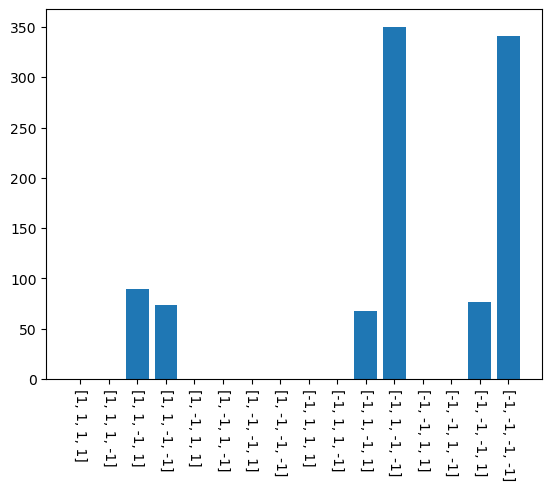

In [96]:
# Test for Quantum + Classic Model with magnetic field in fixed order
start = time()
dyct = {'[1, 1, 1, 1]':0, '[1, 1, 1, -1]':0, '[1, 1, -1, 1]':0, '[1, 1, -1, -1]':0,
       '[1, -1, 1, 1]':0, '[1, -1, 1, -1]':0, '[1, -1, -1, 1]':0, '[1, -1, -1, -1]':0,
       '[-1, 1, 1, 1]':0, '[-1, 1, 1, -1]':0, '[-1, 1, -1, 1]':0, '[-1, 1, -1, -1]':0,
       '[-1, -1, 1, 1]':0, '[-1, -1, 1, -1]':0, '[-1, -1, -1, 1]':0, '[-1, -1, -1, -1]':0}

# Set Parameters
# Parameters are set so that the possibility of each flip is 0.5
J = -0.25 * np.log(0.5) + 0.1 # Coupling Strength
T = 1 # Temperature
B = 0.5 * np.log(0.5) # Magnitude of Magnetic field

# Calculate the Possibility
P1 = np.exp(-((4 * J + 2* B) / T))
P2 = np.exp(-((4 * J - 2* B) / T))
P3 = np.exp(-((-2 * B)/ T))

# Set Trial Numbers
trialnumbers = 1000

# Initialize the circuit
q = QuantumRegister(9)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

# Initialized Spins
inispins = [-1, -1, 1, -1]

for totalloop in range(trialnumbers):
    
    spins = inispins.copy()
    
    for branchloop in range(len(spins)):
        iA_Blargern2J(branchloop)

    dyct[str(spins)] = dyct[str(spins)] + 1

print(float(time() - start), 'seconds')
"""
Result should be:
[1, 1, 1, 1]:0, [1, 1, 1, -1]:0, [1, 1, -1, 1]:0, [1, 1, -1, -1]:0,
[1, -1, 1, 1]:57, [1, -1, 1, -1]:106, [1, -1, -1, 1]:0, [1, -1, -1, -1]:164,
[-1, 1, 1, 1]:0, [-1, 1, 1, -1]:0, [-1, 1, -1, 1]:0, [-1, 1, -1, -1]:0,
[-1, -1, 1, 1]:0, [-1, -1, 1, -1]:335, [-1, -1, -1, 1]:0, [-1, -1, -1, -1]:335
"""
print(dyct)
plt.bar(dyct.keys(), dyct.values())
plt.xticks(ticks = list(dyct.keys()), rotation = 270)

#### Test for situation 0<B<2J (P1 and P3)

69.82161331176758 seconds
{'[1, 1, 1, 1]': 318, '[1, 1, 1, -1]': 77, '[1, 1, -1, 1]': 0, '[1, 1, -1, -1]': 0, '[1, -1, 1, 1]': 358, '[1, -1, 1, -1]': 64, '[1, -1, -1, 1]': 0, '[1, -1, -1, -1]': 0, '[-1, 1, 1, 1]': 0, '[-1, 1, 1, -1]': 0, '[-1, 1, -1, 1]': 0, '[-1, 1, -1, -1]': 0, '[-1, -1, 1, 1]': 96, '[-1, -1, 1, -1]': 87, '[-1, -1, -1, 1]': 0, '[-1, -1, -1, -1]': 0}


([<matplotlib.axis.XTick at 0x29e8d0b2be0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

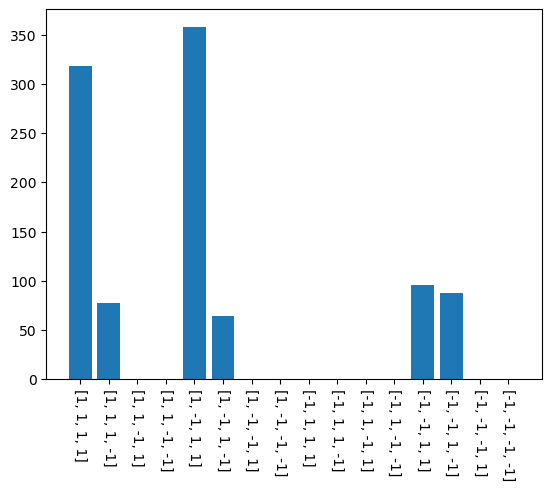

In [104]:
# Test for Quantum + Classic Model with magnetic field in fixed order
start = time()
dyct = {'[1, 1, 1, 1]':0, '[1, 1, 1, -1]':0, '[1, 1, -1, 1]':0, '[1, 1, -1, -1]':0,
       '[1, -1, 1, 1]':0, '[1, -1, 1, -1]':0, '[1, -1, -1, 1]':0, '[1, -1, -1, -1]':0,
       '[-1, 1, 1, 1]':0, '[-1, 1, 1, -1]':0, '[-1, 1, -1, 1]':0, '[-1, 1, -1, -1]':0,
       '[-1, -1, 1, 1]':0, '[-1, -1, 1, -1]':0, '[-1, -1, -1, 1]':0, '[-1, -1, -1, -1]':0}

# Set Parameters
# Parameters are set so that the possibility of each flip is 0.5
J = -0.25 * np.log(0.5) + 0.1 # Coupling Strength
T = 1 # Temperature
B = -0.5 * np.log(0.5) # Magnitude of Magnetic field

# Calculate the Possibility
P1 = np.exp(-((4 * J + 2* B) / T))
P2 = np.exp(-((4 * J - 2* B) / T))
P3 = np.exp(-((2 * B)/ T))

# Set Trial Numbers
trialnumbers = 1000

# Initialize the circuit
q = QuantumRegister(9)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

# Initialized Spins
inispins = [1, 1, -1, 1]

for totalloop in range(trialnumbers):
    
    spins = inispins.copy()
    
    for branchloop in range(len(spins)):
        iA_Bsmallerp2J(branchloop)

    dyct[str(spins)] = dyct[str(spins)] + 1

print(float(time() - start), 'seconds')
"""
Result should be:
[1, 1, 1, 1]:346, [1, 1, 1, -1]:69, [1, 1, -1, 1]:0, [1, 1, -1, -1]:0,
[1, -1, 1, 1]:346, [1, -1, 1, -1]:69, [1, -1, -1, 1]:0, [1, -1, -1, -1]:0,
[-1, 1, 1, 1]:0, [-1, 1, 1, -1]:0, [-1, 1, -1, 1]:0, [-1, 1, -1, -1]:0,
[-1, -1, 1, 1]:83, [-1, -1, 1, -1]:83, [-1, -1, -1, 1]:0, [-1, -1, -1, -1]:0
"""
print(dyct)
plt.bar(dyct.keys(), dyct.values())
plt.xticks(ticks = list(dyct.keys()), rotation = 270)

#### Test for situation 0<B<2J (P2 and P3)

148.94211602210999 seconds
{'[1, 1, 1, 1]': 341, '[1, 1, 1, -1]': 0, '[1, 1, -1, 1]': 321, '[1, 1, -1, -1]': 0, '[1, -1, 1, 1]': 0, '[1, -1, 1, -1]': 0, '[1, -1, -1, 1]': 0, '[1, -1, -1, -1]': 0, '[-1, 1, 1, 1]': 184, '[-1, 1, 1, -1]': 0, '[-1, 1, -1, 1]': 105, '[-1, 1, -1, -1]': 49, '[-1, -1, 1, 1]': 0, '[-1, -1, 1, -1]': 0, '[-1, -1, -1, 1]': 0, '[-1, -1, -1, -1]': 0}


([<matplotlib.axis.XTick at 0x1c206eb0550>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

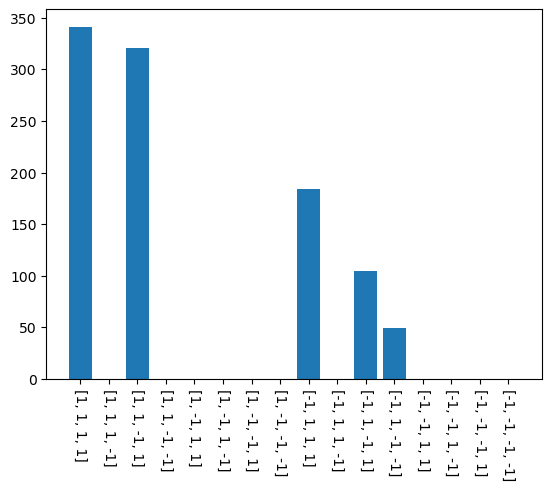

In [7]:
# Test for Quantum + Classic Model with magnetic field in fixed order
start = time()
dyct = {'[1, 1, 1, 1]':0, '[1, 1, 1, -1]':0, '[1, 1, -1, 1]':0, '[1, 1, -1, -1]':0,
       '[1, -1, 1, 1]':0, '[1, -1, 1, -1]':0, '[1, -1, -1, 1]':0, '[1, -1, -1, -1]':0,
       '[-1, 1, 1, 1]':0, '[-1, 1, 1, -1]':0, '[-1, 1, -1, 1]':0, '[-1, 1, -1, -1]':0,
       '[-1, -1, 1, 1]':0, '[-1, -1, 1, -1]':0, '[-1, -1, -1, 1]':0, '[-1, -1, -1, -1]':0}

# Set Parameters
# Parameters are set so that the possibility of each flip is 0.5
J = -0.25 * np.log(0.5) + 0.1 # Coupling Strength
T = 1 # Temperature
B = -0.5 * np.log(0.5) # Magnitude of Magnetic field

# Calculate the Possibility
P1 = np.exp(-((4 * J + 2* B) / T))
P2 = np.exp(-((4 * J - 2* B) / T))
P3 = np.exp(-((2 * B)/ T))

# Set Trial Numbers
trialnumbers = 1000

# Initialize the circuit
q = QuantumRegister(9)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

# Initialized Spins
inispins = [-1, -1, 1, -1]

for totalloop in range(trialnumbers):
    
    spins = inispins.copy()
    
    for branchloop in range(len(spins)):
        iA_Bsmallerp2J(branchloop)

    dyct[str(spins)] = dyct[str(spins)] + 1

print(float(time() - start), 'seconds')
"""
Result should be:
[1, 1, 1, 1]:335, [1, 1, 1, -1]:0, [1, 1, -1, 1]:335 [1, 1, -1, -1]:0,
[1, -1, 1, 1]:0, [1, -1, 1, -1]:0, [1, -1, -1, 1]:0, [1, -1, -1, -1]:0,
[-1, 1, 1, 1]:164, [-1, 1, 1, -1]:0, [-1, 1, -1, 1]:110, [-1, 1, -1, -1]:54,
[-1, -1, 1, 1]:0, [-1, -1, 1, -1]:0, [-1, -1, -1, 1]:0, [-1, -1, -1, -1]:0
"""
print(dyct)
plt.bar(dyct.keys(), dyct.values())
plt.xticks(ticks = list(dyct.keys()), rotation = 270)

#### Test for situation B=2J (P1 and P2)

42.88823056221008 seconds
{'[1, 1, 1, 1]': 384, '[1, 1, 1, -1]': 0, '[1, 1, -1, 1]': 351, '[1, 1, -1, -1]': 0, '[1, -1, 1, 1]': 0, '[1, -1, 1, -1]': 0, '[1, -1, -1, 1]': 265, '[1, -1, -1, -1]': 0, '[-1, 1, 1, 1]': 0, '[-1, 1, 1, -1]': 0, '[-1, 1, -1, 1]': 0, '[-1, 1, -1, -1]': 0, '[-1, -1, 1, 1]': 0, '[-1, -1, 1, -1]': 0, '[-1, -1, -1, 1]': 0, '[-1, -1, -1, -1]': 0}


([<matplotlib.axis.XTick at 0x1c1fa1f2820>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

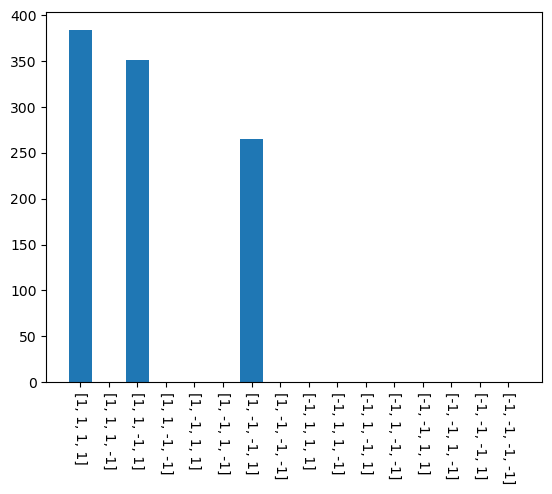

In [27]:
# Test for Quantum + Classic Model with magnetic field in fixed order
start = time()
dyct = {'[1, 1, 1, 1]':0, '[1, 1, 1, -1]':0, '[1, 1, -1, 1]':0, '[1, 1, -1, -1]':0,
       '[1, -1, 1, 1]':0, '[1, -1, 1, -1]':0, '[1, -1, -1, 1]':0, '[1, -1, -1, -1]':0,
       '[-1, 1, 1, 1]':0, '[-1, 1, 1, -1]':0, '[-1, 1, -1, 1]':0, '[-1, 1, -1, -1]':0,
       '[-1, -1, 1, 1]':0, '[-1, -1, 1, -1]':0, '[-1, -1, -1, 1]':0, '[-1, -1, -1, -1]':0}

# Set Parameters
# Parameters are set so that the possibility of each flip is 0.5
J = -0.25 * np.log(0.5) # Coupling Strength
T = 1 # Temperature
B = -0.5 * np.log(0.5) # Magnitude of Magnetic field

# Calculate the Possibility
P1 = np.exp(-((2 * B)) / T) 
P2 = np.exp(-((4 * J + 2* B) / T))

# Set Trial Numbers
trialnumbers = 1000

# Initialize the circuit
q = QuantumRegister(7)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

# Initialized Spins
inispins = [-1, 1, 1, -1]

for totalloop in range(trialnumbers):
    
    spins = inispins.copy()
    
    for branchloop in range(len(spins)):
        iA_Bequalp2J(branchloop)

    dyct[str(spins)] = dyct[str(spins)] + 1

print(float(time() - start), 'seconds')
"""
Result should be:
[1, 1, 1, 1]:375, [1, 1, 1, -1]:0, [1, 1, -1, 1]:375 [1, 1, -1, -1]:0,
[1, -1, 1, 1]:0, [1, -1, 1, -1]:0, [1, -1, -1, 1]:250, [1, -1, -1, -1]:0,
[-1, 1, 1, 1]:0, [-1, 1, 1, -1]:0, [-1, 1, -1, 1]:0, [-1, 1, -1, -1]:0,
[-1, -1, 1, 1]:0, [-1, -1, 1, -1]:0, [-1, -1, -1, 1]:0, [-1, -1, -1, -1]:0
"""
print(dyct)
plt.bar(dyct.keys(), dyct.values())
plt.xticks(ticks = list(dyct.keys()), rotation = 270)

#### Test for situation B>2J (P1, P2 and P3)

38.131160497665405 seconds
{'[1, 1, 1, 1]': 186, '[1, 1, 1, -1]': 116, '[1, 1, -1, 1]': 0, '[1, 1, -1, -1]': 0, '[1, -1, 1, 1]': 198, '[1, -1, 1, -1]': 115, '[1, -1, -1, 1]': 0, '[1, -1, -1, -1]': 0, '[-1, 1, 1, 1]': 60, '[-1, 1, 1, -1]': 63, '[-1, 1, -1, 1]': 0, '[-1, 1, -1, -1]': 0, '[-1, -1, 1, 1]': 129, '[-1, -1, 1, -1]': 133, '[-1, -1, -1, 1]': 0, '[-1, -1, -1, -1]': 0}


([<matplotlib.axis.XTick at 0x1c209a924c0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

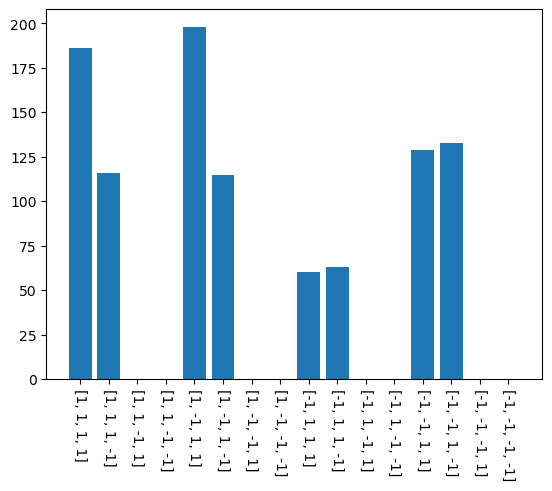

In [45]:
# Test for Quantum + Classic Model with magnetic field in fixed order
start = time()
dyct = {'[1, 1, 1, 1]':0, '[1, 1, 1, -1]':0, '[1, 1, -1, 1]':0, '[1, 1, -1, -1]':0,
       '[1, -1, 1, 1]':0, '[1, -1, 1, -1]':0, '[1, -1, -1, 1]':0, '[1, -1, -1, -1]':0,
       '[-1, 1, 1, 1]':0, '[-1, 1, 1, -1]':0, '[-1, 1, -1, 1]':0, '[-1, 1, -1, -1]':0,
       '[-1, -1, 1, 1]':0, '[-1, -1, 1, -1]':0, '[-1, -1, -1, 1]':0, '[-1, -1, -1, -1]':0}

# Set Parameters
# Parameters are set so that the possibility of each flip is 0.5
J = -0.25 * np.log(0.5) - 0.1 # Coupling Strength
T = 1 # Temperature
B = -0.5 * np.log(0.5) # Magnitude of Magnetic field

# Calculate the Possibility
P1 = np.exp(-((4 * J + 2* B) / T))
P2 = np.exp(-((-4 * J + 2* B) / T))
P3 = np.exp(-((2 * B)) / T)

# Set Trial Numbers
trialnumbers = 1000

# Initialize the circuit
q = QuantumRegister(9)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

# Initialized Spins
inispins = [1, 1, -1, 1]

for totalloop in range(trialnumbers):
    
    spins = inispins.copy()
    
    for branchloop in range(len(spins)):
        iA_Blargerp2J(branchloop)

    dyct[str(spins)] = dyct[str(spins)] + 1

print(float(time() - start), 'seconds')
"""
Result should be:
[1, 1, 1, 1]:196, [1, 1, 1, -1]:116, [1, 1, -1, 1]:0 [1, 1, -1, -1]:0,
[1, -1, 1, 1]:103, [1, -1, 1, -1]:61, [1, -1, -1, 1]:0, [1, -1, -1, -1]:0,
[-1, 1, 1, 1]:61, [-1, 1, 1, -1]:61, [-1, 1, -1, 1]:0, [-1, 1, -1, -1]:0,
[-1, -1, 1, 1]:125, [-1, -1, 1, -1]:125, [-1, -1, -1, 1]:0, [-1, -1, -1, -1]:0
"""
print(dyct)
plt.bar(dyct.keys(), dyct.values())
plt.xticks(ticks = list(dyct.keys()), rotation = 270)

#### Combination (with External Field)

88.85952019691467 seconds
{'[1, 1, 1, 1]': 361, '[1, 1, 1, -1]': 0, '[1, 1, -1, 1]': 387, '[1, 1, -1, -1]': 0, '[1, -1, 1, 1]': 0, '[1, -1, 1, -1]': 0, '[1, -1, -1, 1]': 252, '[1, -1, -1, -1]': 0, '[-1, 1, 1, 1]': 0, '[-1, 1, 1, -1]': 0, '[-1, 1, -1, 1]': 0, '[-1, 1, -1, -1]': 0, '[-1, -1, 1, 1]': 0, '[-1, -1, 1, -1]': 0, '[-1, -1, -1, 1]': 0, '[-1, -1, -1, -1]': 0}


([<matplotlib.axis.XTick at 0x204f71d7580>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

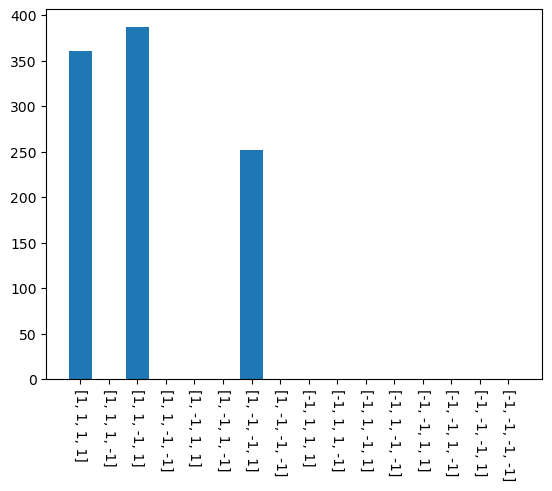

In [8]:
start = time()
dyct = {'[1, 1, 1, 1]':0, '[1, 1, 1, -1]':0, '[1, 1, -1, 1]':0, '[1, 1, -1, -1]':0,
       '[1, -1, 1, 1]':0, '[1, -1, 1, -1]':0, '[1, -1, -1, 1]':0, '[1, -1, -1, -1]':0,
       '[-1, 1, 1, 1]':0, '[-1, 1, 1, -1]':0, '[-1, 1, -1, 1]':0, '[-1, 1, -1, -1]':0,
       '[-1, -1, 1, 1]':0, '[-1, -1, 1, -1]':0, '[-1, -1, -1, 1]':0, '[-1, -1, -1, -1]':0}

# Set Parameters
# Parameters are set so that the possibility of each flip is 0.5
J = -0.25 * np.log(0.5) # Coupling Strength
T = 1 # Temperature
B = -0.5 * np.log(0.5) # Magnitude of Magnetic field

# Set Trial Numbers
trialnumbers = 1000

# Initialized Spins
inispins = [-1, 1, 1, -1]

if B == np.abs(2 * J):
    q = QuantumRegister(7)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)
    
    if B == (-2 * J):
        P1 = np.exp(-((-2 * B)/ T))
        P2 = np.exp(-((4 * J - 2* B) / T))
        for totalloop in range(trialnumbers):
            spins = inispins.copy()
            for branchloop in range(len(spins)):
                iA_Bequaln2J(branchloop)
            dyct[str(spins)] = dyct[str(spins)] + 1
    
    elif B == (2 * J):
        P1 = np.exp(-((2 * B)) / T) 
        P2 = np.exp(-((4 * J + 2* B) / T))
        for totalloop in range(trialnumbers):
            spins = inispins.copy()
            for branchloop in range(len(spins)):
                iA_Bequalp2J(branchloop)
            dyct[str(spins)] = dyct[str(spins)] + 1
else: 
    q = QuantumRegister(9)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)
    if B < (-2 * J):
        P1 = np.exp(-((-4 * J - 2* B) / T))
        P2 = np.exp(-((4 * J - 2* B) / T))
        P3 = np.exp(-((-2 * B)/ T))
        for totalloop in range(trialnumbers):
            spins = inispins.copy()
            for branchloop in range(len(spins)):
                iA_Bsmallern2J(branchloop)
            dyct[str(spins)] = dyct[str(spins)] + 1
    elif B > (-2 * J) and B < 0:
        P1 = np.exp(-((4 * J + 2* B) / T))
        P2 = np.exp(-((4 * J - 2* B) / T))
        P3 = np.exp(-((-2 * B)/ T))
        for totalloop in range(trialnumbers):
            spins = inispins.copy()
            for branchloop in range(len(spins)):
                iA_Blargern2J(branchloop)
            dyct[str(spins)] = dyct[str(spins)] + 1
    elif B < (2 * J) and B > 0:
        P1 = np.exp(-((4 * J + 2* B) / T))
        P2 = np.exp(-((4 * J - 2* B) / T))
        P3 = np.exp(-((2 * B)/ T))
        for totalloop in range(trialnumbers):
            spins = inispins.copy()
            for branchloop in range(len(spins)):
                iA_Bsmallerp2J(branchloop)
            dyct[str(spins)] = dyct[str(spins)] + 1
    elif B > (2 * J):
        P1 = np.exp(-((4 * J + 2* B) / T))
        P2 = np.exp(-((-4 * J + 2* B) / T))
        P3 = np.exp(-((2 * B)) / T)
        for totalloop in range(trialnumbers):
            spins = inispins.copy()
            for branchloop in range(len(spins)):
                iA_Blargerp2J(branchloop)
            dyct[str(spins)] = dyct[str(spins)] + 1

print(float(time() - start), 'seconds')
print(dyct)
plt.bar(dyct.keys(), dyct.values())
plt.xticks(ticks = list(dyct.keys()), rotation = 270)

### 2D Ising Model (without magnetic field)

#### Classic Monte Carlo Method

In [2]:
import copy

# Define a function to calculate the energy of the lattice
def calculate_energy(s, rindex, cindex):
    energy = 0
    energy = -J * s[rindex][cindex] * (s[rindex - 1][cindex] + s[(rindex + 1) % L][cindex]
                    + s[rindex][(cindex + 1) % L] + s[rindex][cindex - 1] )
    return energy

def deltaEnergy(s, rindex, cindex):
    temps = copy.deepcopy(s)
    temps[rindex][cindex] = -1 * temps[rindex][cindex]
    return calculate_energy(temps, rindex, cindex) - calculate_energy(s, rindex, cindex)

# Auxilliary code for dictionaries
def encode(dyctionary, intkey):
    strkey = str(intkey)
    if strkey in list(dyctionary.keys()):
        dyctionary[strkey] += 1
    else:
        dyctionary[strkey] = 1

0.14792537689208984 seconds
{'[[-1, 1, -1], [1, -1, -1], [-1, -1, 1]]': 268, '[[-1, 1, -1], [1, -1, -1], [-1, -1, -1]]': 242, '[[-1, 1, -1], [1, 1, -1], [-1, -1, -1]]': 240, '[[-1, 1, -1], [1, 1, -1], [-1, -1, 1]]': 250}


([<matplotlib.axis.XTick at 0x210faef91f0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

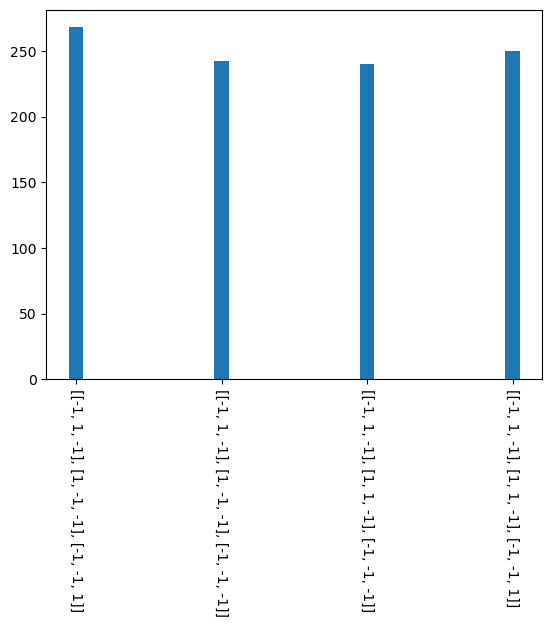

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
J = -0.125 * np.log(0.5)  # coupling constant
k_B = 1.0  # Boltzmann constant
T = 1.0  # temperature
L = 3   # lattice size
N = L**2  # number of spins
n_steps = 1000  # number of simulation steps
dyct = {}

start = time()
# Initialize the lattice
#s = np.random.choice([-1, 1], size=(L, L))
#s = [[1 for col in range(L)] for row in range(L)]
s = [[1, -1, 1], [-1, 1, 1], [1, 1, -1]]

"""
# Define a function to calculate the magnetization of the lattice
def calculate_magnetization(s):
    return np.sum(s)
"""

"""
# Initialize the energy and magnetization arrays
energy = np.zeros(n_steps)
magnetization = np.zeros(n_steps)
"""


# Monte Carlo simulation using the Metropolis algorithm
for step in range(n_steps):
    #Initialize Spin for every loop
    st = copy.deepcopy(s)
    
    # Calculate the energy change and perform ising interaction
    for i in range(L):
        for j in range(L):
            if deltaEnergy(st, i, j) <= 0:
                st[i][j] = -1 * st[i][j]
            else:
                if random.random() < np.exp(-deltaEnergy(st, i, j)/(k_B*T)):
                    st[i][j] = -1 * st[i][j]
                    #print('error')
    # Added result to dictionary
    encode(dyct, st)
    #print(dyct)

print(float(time() - start), 'seconds')
    

"""
    # Update the energy and magnetization arrays
    energy[step] = calculate_energy(s)
    magnetization[step] = calculate_magnetization(s)
"""

#print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in s]))

print(dyct)
plt.bar(dyct.keys(), dyct.values(), width = 0.1)
plt.xticks(ticks = list(dyct.keys()), rotation = 270)

#### Quantum + Classic Method

##### Modularization

In [15]:
# Quantum Cirucit
def twoDwithoutH(rindex, cindex):
    
    # Initialize circuit
    qc = QuantumCircuit(q, c)
        
    qc.u(2 * np.arccos(np.sqrt(1 - P1)), 0, 0, q[9])
    qc.u(2 * np.arccos(np.sqrt(1 - P2)), 0, 0, q[10])

    if spins[rindex][cindex] == 1:
        qc.x(q[8])
            
    if spins[(rindex + 1) % L][cindex] == 1:
        qc.x(q[0])

    if spins[rindex - 1][cindex] == 1:
        qc.x(q[1])
    
    if spins[rindex][(cindex + 1) % L] == 1:
        qc.x(q[2])
    
    if spins[rindex][cindex - 1] == 1:
        qc.x(q[3])
    
    # Operation 1
    qc.x(q[2])
    qc.x(q[3])
    qc.mcx([q[0],q[1],q[2], q[3]], q[4])
    qc.x(q[2])
    qc.x(q[3])

    # Operation 2
    qc.x(q[1])
    qc.x(q[3])
    qc.mcx([q[0],q[1],q[2], q[3]], q[4])
    qc.x(q[1])
    qc.x(q[3])
    
    # Operation 3
    qc.x(q[1])
    qc.x(q[2])
    qc.mcx([q[0],q[1],q[2], q[3]], q[4])
    qc.x(q[1])
    qc.x(q[2])
    
    # Operation 4
    qc.x(q[0])
    qc.x(q[3])
    qc.mcx([q[0],q[1],q[2], q[3]], q[4])
    qc.x(q[0])
    qc.x(q[3])
    
    # Operation 5
    qc.x(q[0])
    qc.x(q[2])
    qc.mcx([q[0],q[1],q[2], q[3]], q[4])
    qc.x(q[0])
    qc.x(q[2])
    
    # Operation 6
    qc.x(q[0])
    qc.x(q[1])
    qc.mcx([q[0],q[1],q[2], q[3]], q[4])
    qc.x(q[0])
    qc.x(q[1])
    
    # Operation 7
    qc.x(q[0])
    qc.mcx([q[0],q[1],q[2], q[3]], q[5])
    qc.x(q[0])
    
    # Operation 8
    qc.x(q[1])
    qc.mcx([q[0],q[1],q[2], q[3]], q[5])
    qc.x(q[1])
    
    # Operation 9
    qc.x(q[2])
    qc.mcx([q[0],q[1],q[2], q[3]], q[5])
    qc.x(q[2])
    
    # Operation 10
    qc.x(q[3])
    qc.mcx([q[0],q[1],q[2], q[3]], q[5])
    qc.x(q[3])
    
    # Operation 11
    qc.x(q[1])
    qc.x(q[2])
    qc.x(q[3])
    qc.mcx([q[0],q[1],q[2], q[3]], q[6])
    qc.x(q[1])
    qc.x(q[2])
    qc.x(q[3])
    
    # Operation 12
    qc.x(q[0])
    qc.x(q[2])
    qc.x(q[3])
    qc.mcx([q[0],q[1],q[2], q[3]], q[6])
    qc.x(q[0])
    qc.x(q[2])
    qc.x(q[3])
    
    # Operation 13
    qc.x(q[0])
    qc.x(q[1])
    qc.x(q[3])
    qc.mcx([q[0],q[1],q[2], q[3]], q[6])
    qc.x(q[0])
    qc.x(q[1])
    qc.x(q[3])
    
    # Operation 14
    qc.x(q[0])
    qc.x(q[1])
    qc.x(q[2])
    qc.mcx([q[0],q[1],q[2], q[3]], q[6])
    qc.x(q[0])
    qc.x(q[1])
    qc.x(q[2])
    
    # Operation 15
    qc.mcx([q[0],q[1],q[2], q[3]], q[5])
    qc.cx(q[5], q[7])
    
    # Operation 16
    qc.x(q[0])
    qc.x(q[1])
    qc.x(q[2])
    qc.x(q[3])
    qc.mcx([q[0],q[1],q[2], q[3]], q[6])
    qc.cx(q[6], q[7])
    qc.x(q[0])
    qc.x(q[1])
    qc.x(q[2])
    qc.x(q[3])
    
    # Operation 17
    qc.x(q[8])
    qc.ccx(q[5], q[8], q[11])
    qc.x(q[8])
    
    # Operation 18
    qc.ccx(q[6], q[8], q[11])
    
    # Operation 19
    qc.cx(q[4], q[8])
    
    # Operation 20
    qc.cx(q[11], q[8])
    
    # Operation 21
    qc.cswap(q[7], q[9], q[10])
    
    # Operation 22
    qc.x(q[4])
    qc.x(q[11])
    qc.mcx([q[4], q[9], q[11]],q[8])
    qc.x(q[4])
    qc.x(q[11])
    
    # Operation 23
    qc.measure(q[8], c)
    backend = Aer.get_backend('qasm_simulator')
    shots = 1024
    results = execute(qc, backend, shots=shots).result()
    counts = results.get_counts()

    newstat = int(list(counts.keys())[0])
    if newstat == 1:
        spins[rindex][cindex] = 1
    elif newstat == 0:
        spins[rindex][cindex] = -1

80.17846059799194 seconds
{'[[-1, 1, -1], [1, 1, -1], [-1, -1, 1]]': 24, '[[-1, 1, -1], [1, -1, -1], [-1, -1, -1]]': 30, '[[-1, 1, -1], [1, -1, -1], [-1, -1, 1]]': 20, '[[-1, 1, -1], [1, 1, -1], [-1, -1, -1]]': 26}


<BarContainer object of 4 artists>

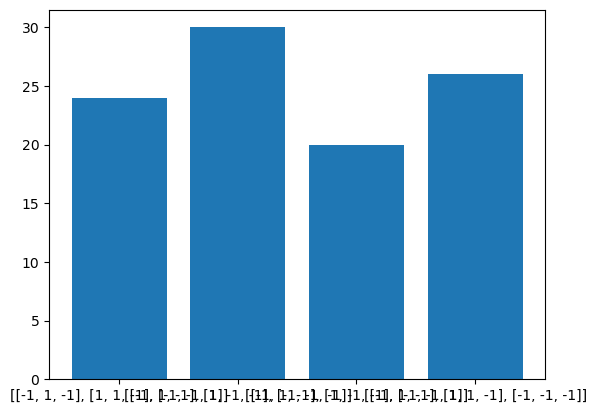

In [16]:
start = time()

# Set Parameters
J = -0.125*np.log(0.5) # Coupling Strength
T = 1 # Temperature
L = 3 # Dimensions
dyct = {} # Reocrd Dictionary

# Calculate the Possibility
P1 = np.exp(-4 * J / T)
P2 = np.exp(-8 * J / T)


# Initialize the circuit
q = QuantumRegister(12)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

for t in range(100):
    
    spins = s = [[1, -1, 1], [-1, 1, 1], [1, 1, -1]]
    
    for temp10 in range (0, L):
        for temp11 in range (0, L):
            twoDwithoutH(temp10, temp11)
    
    encode(dyct, spins)

print(float(time() - start), 'seconds')
print(dyct)
plt.bar(dyct.keys(), dyct.values())

In [74]:
# Set Parameters
J = -0.125*np.log(0.5) # Coupling Strength
T = 1 # Temperature
L = 2 # Dimensions
dyct = {} # Reocrd Dictionary

# Calculate the Possibility
P1 = np.exp(-4 * J / T)
P2 = np.exp(-8 * J / T)

q = QuantumRegister(12)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

spins = [[-1, -1], [-1, -1]]

temp12= 0
temp13 = 1
twoDwithoutH(temp12, temp13)
print(spins)

[[-1, -1], [-1, -1]]


### Full Adder Optimized Version

#### Modularization

In [1]:
def withoutHFA(rindex, cindex):
    
    # Initialize circuit
    qc = QuantumCircuit(q, c)
        
    qc.u(2 * np.arccos(np.sqrt(1 - P1)), 0, 0, q[10])
    qc.u(2 * np.arccos(np.sqrt(1 - P2)), 0, 0, q[11])

    if spins[rindex][cindex] == 1:
        qc.x(q[4])
        qc.x(q[5])
            
    if spins[(rindex + 1) % L][cindex] == 1:
        qc.x(q[0])

    if spins[rindex - 1][cindex] == 1:
        qc.x(q[1])
    
    if spins[rindex][(cindex + 1) % L] == 1:
        qc.x(q[2])
    
    if spins[rindex][cindex - 1] == 1:
        qc.x(q[3])
    
    # Operation 1
    qc.ccx(q[0], q[1], q[6])

    # Operation 2
    qc.cx(q[0], q[1])
    
    # Operation 3
    qc.ccx(q[1], q[4], q[6])
    
    # Operation 4
    qc.cx(q[1], q[4])
    
    # Operation 5
    #qc.cx(q[0], q[1])
    
    # Operation 6
    qc.ccx(q[2], q[3], q[7])
    
    # Operation 7
    qc.cx(q[2], q[3])
    
    # Operation 8
    qc.ccx(q[3], q[5], q[7])
    
    # Operation 9
    qc.cx(q[3], q[5])
    
    # Operation 10
    #qc.cx(q[2], q[3])
    
    # Operation 11
    qc.mcx([q[4],q[5],q[6], q[7]], q[9])
    
    # Operation 12
    qc.x(q[4])
    qc.x(q[5])
    qc.x(q[6])
    qc.x(q[7])
    qc.mcx([q[4],q[5],q[6], q[7]], q[9])
    qc.x(q[4])
    qc.x(q[5])
    qc.x(q[6])
    qc.x(q[7])
    
    # Operation 13
    qc.x(q[4])
    qc.x(q[6])
    qc.x(q[7])
    qc.mcx([q[4],q[5],q[6], q[7]], q[8])
    qc.x(q[4])
    qc.x(q[6])
    qc.x(q[7])
    
    # Operation 14
    qc.x(q[5])
    qc.x(q[6])
    qc.x(q[7])
    qc.mcx([q[4],q[5],q[6], q[7]], q[8])
    qc.x(q[5])
    qc.x(q[6])
    qc.x(q[7])
    
    # Operation 15
    qc.x(q[5])
    qc.mcx([q[4],q[5],q[6], q[7]], q[8])
    qc.x(q[5])
    
    # Operation 16
    qc.x(q[4])
    qc.mcx([q[4],q[5],q[6], q[7]], q[8])
    qc.x(q[4])
    
    # Operation 17
    qc.reset(q[4])
    if spins[rindex][cindex] == 1:
        qc.x(q[4])
    
    # Operation 18
    qc.x(q[8])
    qc.x(q[9])
    qc.ccx(q[8], q[9], q[4])
    qc.x(q[8])
    qc.x(q[9])
    
    # Operation 19
    qc.ccx(q[8], q[10], q[4])
    
    # Operation 20
    qc.ccx(q[9], q[11], q[4])
    
    # Operation 21
    qc.measure(q[4], c)
    backend = Aer.get_backend('qasm_simulator')
    shots = 1024
    results = execute(qc, backend, shots=shots).result()
    counts = results.get_counts()

    newstat = int(list(counts.keys())[0])
    if newstat == 1:
        spins[rindex][cindex] = 1
    elif newstat == 0:
        spins[rindex][cindex] = -1

120.86369824409485 seconds
{'[[-1, 1], [1, 1]]': 50, '[[-1, 1], [1, -1]]': 50}


<BarContainer object of 2 artists>

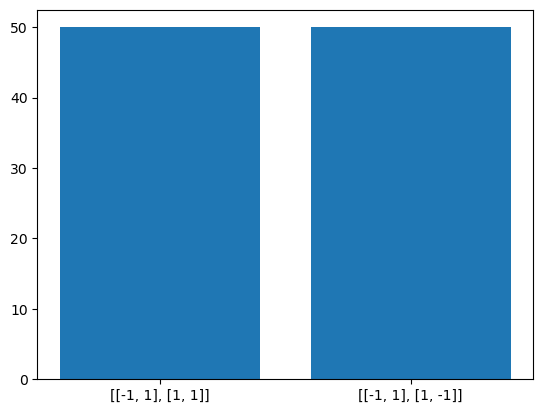

In [7]:
start = time()

# Set Parameters
J = -0.125*np.log(0.5) # Coupling Strength
T = 1 # Temperature
L = 2 # Dimensions
dyct = {} # Reocrd Dictionary

# Calculate the Possibility
P1 = np.exp(-4 * J / T)
P2 = np.exp(-8 * J / T)


# Initialize the circuit
q = QuantumRegister(12)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

for t in range(100):
    
    spins = [[1, -1], [-1, 1]]
    
    for temp10 in range (0, L):
        for temp11 in range (0, L):
            withoutHFA(temp10, temp11)
    
    encode(dyct, spins)

print(float(time() - start), 'seconds')
print(dyct)
plt.bar(dyct.keys(), dyct.values())

### Version 3.0 Optimization

#### Modularization

In [8]:
def withoutH21D(rindex, cindex):
    
    # Initialize circuit
    qc = QuantumCircuit(q, c)
        
    qc.u(2 * np.arccos(np.sqrt(1 - P1)), 0, 0, q[8])
    qc.u(2 * np.arccos(np.sqrt(1 - P2)), 0, 0, q[9])

    if spins[rindex][cindex] == 1:
        qc.x(q[2])
            
    if spins[(rindex - 1) % L][cindex] == 1:
        qc.x(q[0])

    if spins[(rindex + 1) % L][cindex] == 1:
        qc.x(q[1])
    
    if spins[rindex][(cindex - 1) % L] == 1:
        qc.x(q[3])
    
    if spins[rindex][(cindex + 1) % L] == 1:
        qc.x(q[4])
    
    # Operation 1
    qc.mcx([q[0], q[1], q[2]], q[5])

    # Operation 2
    qc.x(q[0])
    qc.x(q[1])
    qc.x(q[2])
    qc.mcx([q[0], q[1], q[2]], q[5])
    qc.x(q[0])
    qc.x(q[1])
    qc.x(q[2])
    
    # Operation 3
    qc.mcx([q[2], q[3], q[4]], q[6])
    
    # Operation 4
    qc.x(q[2])
    qc.x(q[3])
    qc.x(q[4])
    qc.mcx([q[2], q[3], q[4]], q[6])
    qc.x(q[2])
    qc.x(q[3])
    qc.x(q[4])
    
    # Operation 5
    qc.x(q[3])
    qc.x(q[4])
    qc.mcx([q[0], q[1], q[3], q[4]], q[7])
    qc.x(q[3])
    qc.x(q[4])
    
    # Operation 6
    qc.x(q[0])
    qc.x(q[1])
    qc.mcx([q[0], q[1], q[3], q[4]], q[7])
    qc.x(q[0])
    qc.x(q[1])
    
    # Operation 7
    qc.x(q[5])
    qc.x(q[6])
    qc.ccx(q[5], q[6], q[2])
    qc.x(q[5])
    qc.x(q[6])
    
    # Operation 8
    qc.cx(q[7], q[2])
    
    # Operation 9
    qc.mcx([q[5], q[6], q[9]], q[2])
    
    # Operation 10
    qc.x(q[5])
    qc.x(q[7])
    qc.mcx([q[5], q[6], q[7], q[8]], q[2])
    qc.x(q[5])
    qc.x(q[7])
    
    # Operation 11
    qc.x(q[6])
    qc.x(q[7])
    qc.mcx([q[5], q[6], q[7], q[8]], q[2])
    qc.x(q[6])
    qc.x(q[7])
    
    
    # Operation 12
    qc.measure(q[2], c)
    backend = Aer.get_backend('qasm_simulator')
    shots = 1024
    results = execute(qc, backend, shots=shots).result()
    counts = results.get_counts()

    newstat = int(list(counts.keys())[0])
    if newstat == 1:
        spins[rindex][cindex] = 1
    elif newstat == 0:
        spins[rindex][cindex] = -1

51.81509590148926 seconds
{'[[-1, 1, -1], [1, -1, -1], [-1, -1, -1]]': 20, '[[-1, 1, -1], [1, 1, -1], [-1, -1, -1]]': 23, '[[-1, 1, -1], [1, 1, -1], [-1, -1, 1]]': 37, '[[-1, 1, -1], [1, -1, -1], [-1, -1, 1]]': 20}


<BarContainer object of 4 artists>

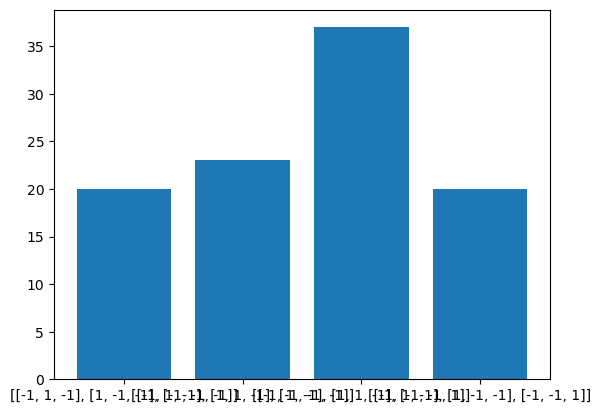

In [13]:
start = time()

# Set Parameters
J = -0.125*np.log(0.5) # Coupling Strength
T = 1 # Temperature
L = 3 # Dimensions
dyct = {} # Reocrd Dictionary

# Calculate the Possibility
P1 = np.exp(-4 * J / T)
P2 = np.exp(-8 * J / T)


# Initialize the circuit
q = QuantumRegister(10)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

for t in range(100):
    
    spins = s = [[1, -1, 1], [-1, 1, 1], [1, 1, -1]]
    
    for temp10 in range (0, L):
        for temp11 in range (0, L):
            withoutH21Dtest(temp10, temp11)
    
    encode(dyct, spins)

print(float(time() - start), 'seconds')
print(dyct)
plt.bar(dyct.keys(), dyct.values())

In [10]:
def withoutH21Dtest(rindex, cindex):
    
    # Initialize circuit
    qc = QuantumCircuit(q, c)
        
    qc.u(2 * np.arccos(np.sqrt(1 - P1)), 0, 0, q[8])
    qc.u(2 * np.arccos(np.sqrt(1 - P2)), 0, 0, q[9])

    if spins[rindex][cindex] == 1:
        qc.x(q[2])
            
    if spins[(rindex - 1) % L][cindex] == 1:
        qc.x(q[0])

    if spins[(rindex + 1) % L][cindex] == 1:
        qc.x(q[1])
    
    if spins[rindex][(cindex - 1) % L] == 1:
        qc.x(q[3])
    
    if spins[rindex][(cindex + 1) % L] == 1:
        qc.x(q[4])
    
    # Operation 1
    qc.mcx([q[0], q[1], q[2]], q[5])

    # Operation 2
    qc.x(q[0])
    qc.x(q[1])
    qc.x(q[2])
    qc.mcx([q[0], q[1], q[2]], q[5])
    qc.x(q[0])
    qc.x(q[1])
    qc.x(q[2])
    
    # Operation 3
    qc.mcx([q[2], q[3], q[4]], q[6])
    
    # Operation 4
    qc.x(q[2])
    qc.x(q[3])
    qc.x(q[4])
    qc.mcx([q[2], q[3], q[4]], q[6])
    qc.x(q[2])
    qc.x(q[3])
    qc.x(q[4])
    
    # Operation 5
    qc.x(q[3])
    qc.x(q[4])
    qc.mcx([q[0], q[1], q[3], q[4]], q[7])
    qc.x(q[3])
    qc.x(q[4])
    
    # Operation 6
    qc.x(q[0])
    qc.x(q[1])
    qc.mcx([q[0], q[1], q[3], q[4]], q[7])
    qc.x(q[0])
    qc.x(q[1])
    
    # Operation 7
    qc.x(q[5])
    qc.x(q[6])
    qc.ccx(q[5], q[6], q[2])
    qc.x(q[5])
    qc.x(q[6])
    
    # Operation 8
    qc.cx(q[7], q[2])
    
    # Operation 9
    qc.mcx([q[5], q[6], q[9]], q[2])
    
    # Operation 10
    qc.x(q[5])
    qc.x(q[7])
    qc.mcx([q[5], q[6], q[7], q[8]], q[2])
    qc.x(q[5])
    qc.x(q[7])
    
    # Operation 11
    qc.x(q[6])
    qc.x(q[7])
    qc.mcx([q[5], q[6], q[7], q[8]], q[2])
    qc.x(q[6])
    qc.x(q[7])
    
    
    # Operation 12
    qc.measure(q[2], c)
    backend = Aer.get_backend('qasm_simulator')
    shots = 1
    results = execute(qc, backend, shots=shots).result()
    counts = results.get_counts()

    newstat = int(list(counts.keys())[0])
    if newstat == 1:
        spins[rindex][cindex] = 1
    elif newstat == 0:
        spins[rindex][cindex] = -1